# AUTOMATIC MILKING SYSTEMS (AMSs)

## ---------------------------------------------------------

###  Neural and Evolutionary Learning


In [1]:
import os
import copy
import torch
import json
import time
import math
import csv
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import seaborn as sns
import numpy as np
import random
from scipy.stats import wilcoxon
from scipy.stats import friedmanchisquare
from sklearn.linear_model import LinearRegression
from gpolnel.operators.variators import swap_xo, prm_subtree_mtn
from gpolnel.utils.inductive_programming import function_map, prm_reconstruct_tree, _get_tree_depth

import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from tqdm import tqdm
#from mlxtend.plotting import plot_decision_regions
from gpolnel.utils.tree import Tree
from gpolnel.problems.inductive_programming import SML
#from gpolnel.utils.utils import train_test_split
from gpolnel.utils.ffunctions import Ffunctions
from gpolnel.utils.tree import Tree
from gpolnel.utils.inductive_programming import function_map, _get_tree_depth
from gpolnel.algorithms.genetic_algorithm import GeneticAlgorithm, GSGP
from gpolnel.operators.initializers import grow, prm_grow, ERC, Terminal
from gpolnel.problems.problem import Problem
from gpolnel.operators.selectors import prm_tournament
#from gpolnel.operators.variators import prm_efficient_gs_mtn
from gpolnel.problems.inductive_programming import SMLGS, SML
from gpolnel.operators.variators import prm_gs_xo, prm_gs_mtn, prm_efficient_gs_xo, prm_efficient_gs_mtn
import codecs
import neat

#from gpolnel.operators.variators import prm_efficient_gs_mtn
#from gpolnel.operators.selectors import prm_tournament

In [2]:
#First we read the dataset giving in csv file

data = pd.read_csv("data_project_nel.csv")
y_fat = pd.read_csv("y_fat.csv")
y_lactose = pd.read_csv("y_lactose.csv")
y_protein = pd.read_csv("y_protein.csv")

## We proceed to analyze the data and check what preprocessing we need to do. 

In [3]:
data.head()

,lactation,delivery_age_years,dim,dry_days,forage_kg_day,rumination_min_day,milk_kg_day,milk_kg_min_robot,milkings_day,errors_by_100_milkings,high_cdt_by_100_milkings,watery_by_100_milkings,refusals_by_milking,colostrum_separated_kg
0,7,7.750000,414,56.0,4.310918,434.814010,34.082367,3.695699,2.478261,2.046784,0.0,0.000000,0.077973,0.0
1,8,9.083333,357,78.0,4.167087,589.500000,36.170868,4.024165,2.176471,0.900901,0.0,0.000000,0.014157,0.0
2,6,7.666667,315,69.0,4.903333,542.577778,43.371746,2.715252,2.387302,1.063830,0.0,0.132979,0.045213,12.8
3,7,8.666667,362,69.0,4.294724,628.371901,41.683149,2.733291,2.193370,1.763224,0.0,0.000000,0.061713,16.2
4,5,6.500000,427,58.0,4.798618,479.334112,37.916393,1.888608,3.142857,0.745156,0.0,0.000000,0.444858,20.2


In [4]:
data.shape

(324, 14)

In [5]:
y_fat.head()

,fat_percent
0,3.787156
1,3.645519
2,3.458251
3,3.407140
4,4.902554


In [6]:
y_fat.shape

(324, 1)

In [7]:
y_lactose.head()

,lactose_percent
0,4.953503
1,4.983128
2,4.889104
3,4.868969
4,4.845402


In [8]:
y_lactose.shape

(324, 1)

In [9]:
y_protein.head()

,protein_percent
0,3.511685
1,3.470806
2,3.370124
3,3.221164
4,3.395152


In [10]:
y_protein.shape

(324, 1)

In [11]:
data = pd.concat([data, y_lactose, y_fat, y_protein], axis=1)

In [12]:
data.head()

,lactation,delivery_age_years,dim,dry_days,forage_kg_day,rumination_min_day,milk_kg_day,milk_kg_min_robot,milkings_day,errors_by_100_milkings,high_cdt_by_100_milkings,watery_by_100_milkings,refusals_by_milking,colostrum_separated_kg,lactose_percent,fat_percent,protein_percent
0,7,7.750000,414,56.0,4.310918,434.814010,34.082367,3.695699,2.478261,2.046784,0.0,0.000000,0.077973,0.0,4.953503,3.787156,3.511685
1,8,9.083333,357,78.0,4.167087,589.500000,36.170868,4.024165,2.176471,0.900901,0.0,0.000000,0.014157,0.0,4.983128,3.645519,3.470806
2,6,7.666667,315,69.0,4.903333,542.577778,43.371746,2.715252,2.387302,1.063830,0.0,0.132979,0.045213,12.8,4.889104,3.458251,3.370124
3,7,8.666667,362,69.0,4.294724,628.371901,41.683149,2.733291,2.193370,1.763224,0.0,0.000000,0.061713,16.2,4.868969,3.407140,3.221164
4,5,6.500000,427,58.0,4.798618,479.334112,37.916393,1.888608,3.142857,0.745156,0.0,0.000000,0.444858,20.2,4.845402,4.902554,3.395152


In [13]:
data.isnull().sum()

lactation                     0
delivery_age_years            0
dim                           0
dry_days                    147
forage_kg_day                 0
rumination_min_day            0
milk_kg_day                   0
milk_kg_min_robot             0
milkings_day                  0
errors_by_100_milkings        0
high_cdt_by_100_milkings      0
watery_by_100_milkings        0
refusals_by_milking           0
colostrum_separated_kg        0
lactose_percent               0
fat_percent                   0
protein_percent               0
dtype: int64

In [14]:
data.drop('dry_days', axis=1, inplace=True)

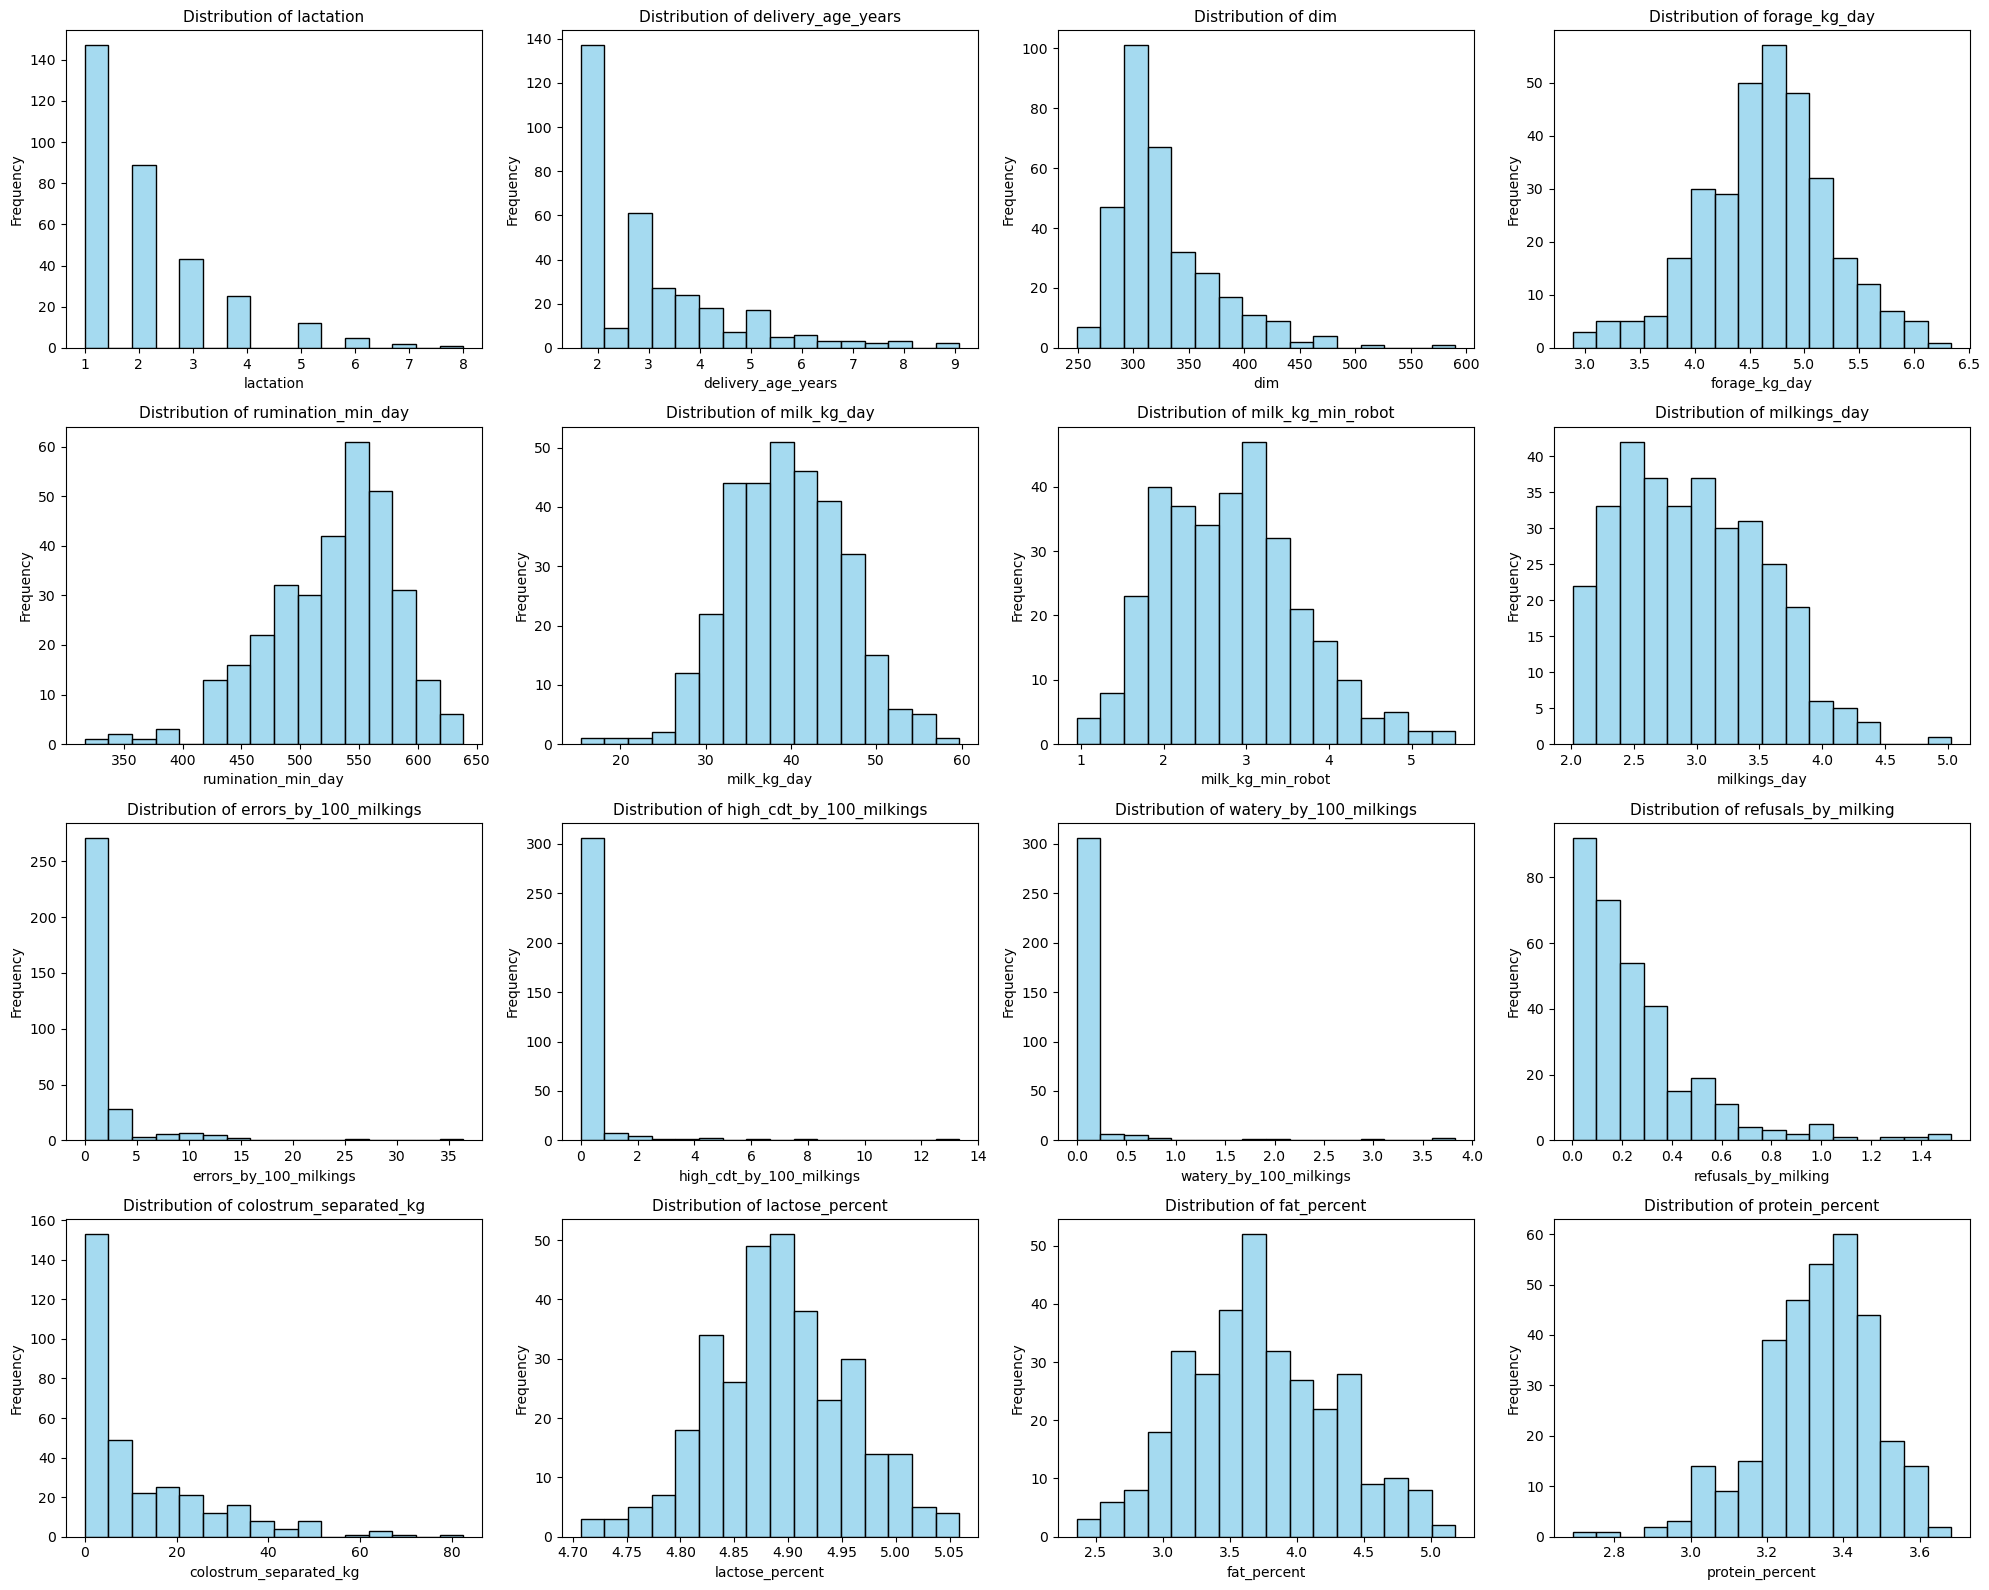

In [15]:
num_columns = len(data.columns)

# Number of rows and columns for subplots
n_rows = 4
n_cols = 4

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 16))

# Flatten the axes array 
axes = axes.flatten()

# Plot each column
for i, column in enumerate(data.columns):
    sns.histplot(data[column], bins=16, kde=False, color='skyblue', ax=axes[i], edgecolor='black')
    axes[i].set_title(f'Distribution of {column}', fontsize=11)
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequency')

# Remove any unused subplots
for j in range(i+1, n_rows*n_cols):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [16]:
#lactation is categorical so we did one hot encoding here
data = pd.get_dummies(data, columns=['lactation'])
data.iloc[:, -7:] = data.iloc[:, -7:].astype(int)

/var/folders/rk/jdn7ny3s5pz59wz4cb1y33q40000gn/T/ipykernel_48180/239395984.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0      0
1      0
2      0
3      0
4      0
      ..
319    0
320    0
321    0
322    0
323    0
Name: lactation_2, Length: 324, dtype: int64' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  data.iloc[:, -7:] = data.iloc[:, -7:].astype(int)
/var/folders/rk/jdn7ny3s5pz59wz4cb1y33q40000gn/T/ipykernel_48180/239395984.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0      0
1      0
2      0
3      0
4      0
      ..
319    0
320    0
321    0
322    0
323    0
Name: lactation_3, Length: 324, dtype: int64' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  data.iloc[:, -7:] = data.iloc[:, -7:].astype(int)
/var/folders/rk/jdn7ny3s5pz59wz4cb1y

In [17]:
data.head()

,delivery_age_years,dim,forage_kg_day,rumination_min_day,milk_kg_day,milk_kg_min_robot,milkings_day,errors_by_100_milkings,high_cdt_by_100_milkings,watery_by_100_milkings,...,fat_percent,protein_percent,lactation_1,lactation_2,lactation_3,lactation_4,lactation_5,lactation_6,lactation_7,lactation_8
0,7.750000,414,4.310918,434.814010,34.082367,3.695699,2.478261,2.046784,0.0,0.000000,...,3.787156,3.511685,False,0,0,0,0,0,1,0
1,9.083333,357,4.167087,589.500000,36.170868,4.024165,2.176471,0.900901,0.0,0.000000,...,3.645519,3.470806,False,0,0,0,0,0,0,1
2,7.666667,315,4.903333,542.577778,43.371746,2.715252,2.387302,1.063830,0.0,0.132979,...,3.458251,3.370124,False,0,0,0,0,1,0,0
3,8.666667,362,4.294724,628.371901,41.683149,2.733291,2.193370,1.763224,0.0,0.000000,...,3.407140,3.221164,False,0,0,0,0,0,1,0
4,6.500000,427,4.798618,479.334112,37.916393,1.888608,3.142857,0.745156,0.0,0.000000,...,4.902554,3.395152,False,0,0,0,1,0,0,0


In [18]:
spearman_corr_matrix = data.corr(method='spearman')

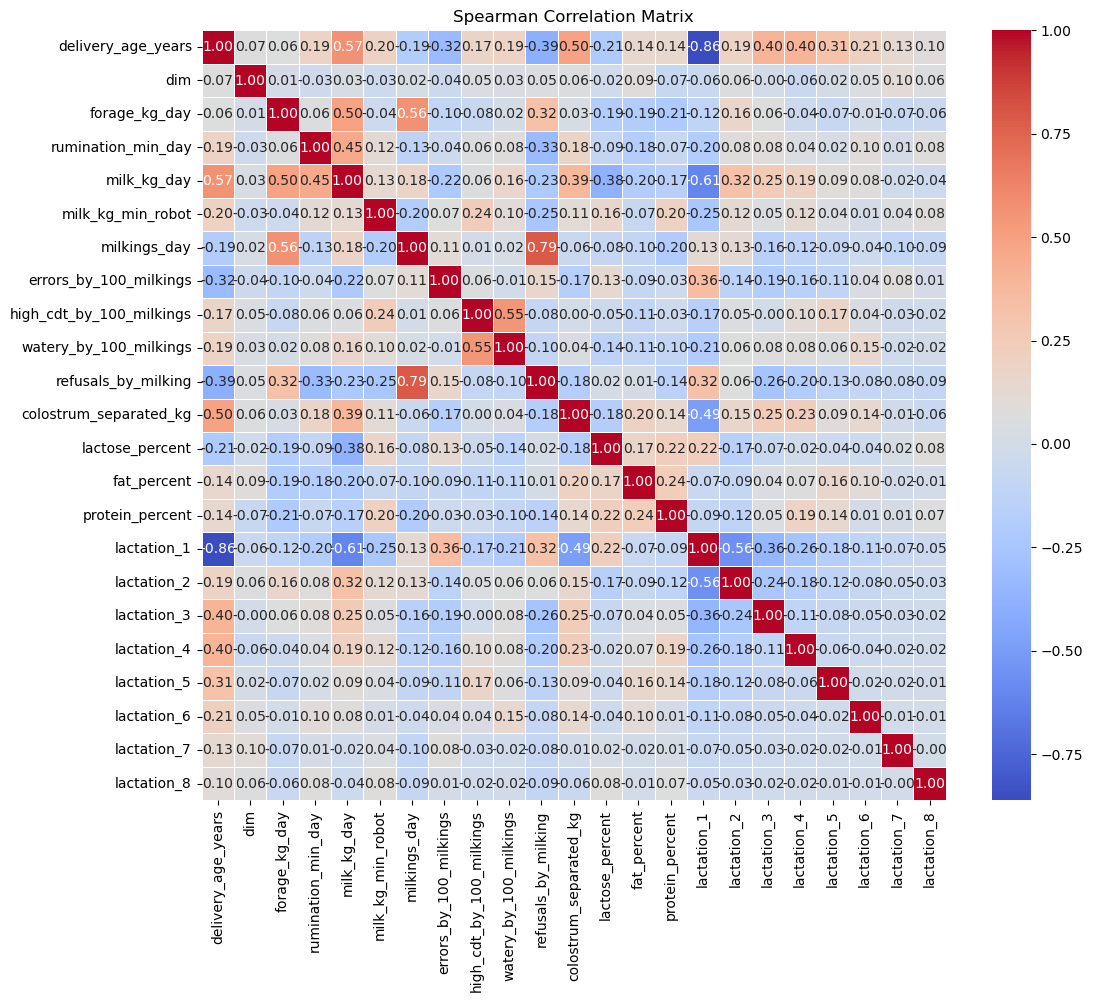

In [19]:
plt.figure(figsize=(12, 10))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(spearman_corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=.5)
plt.title('Spearman Correlation Matrix')
plt.show()

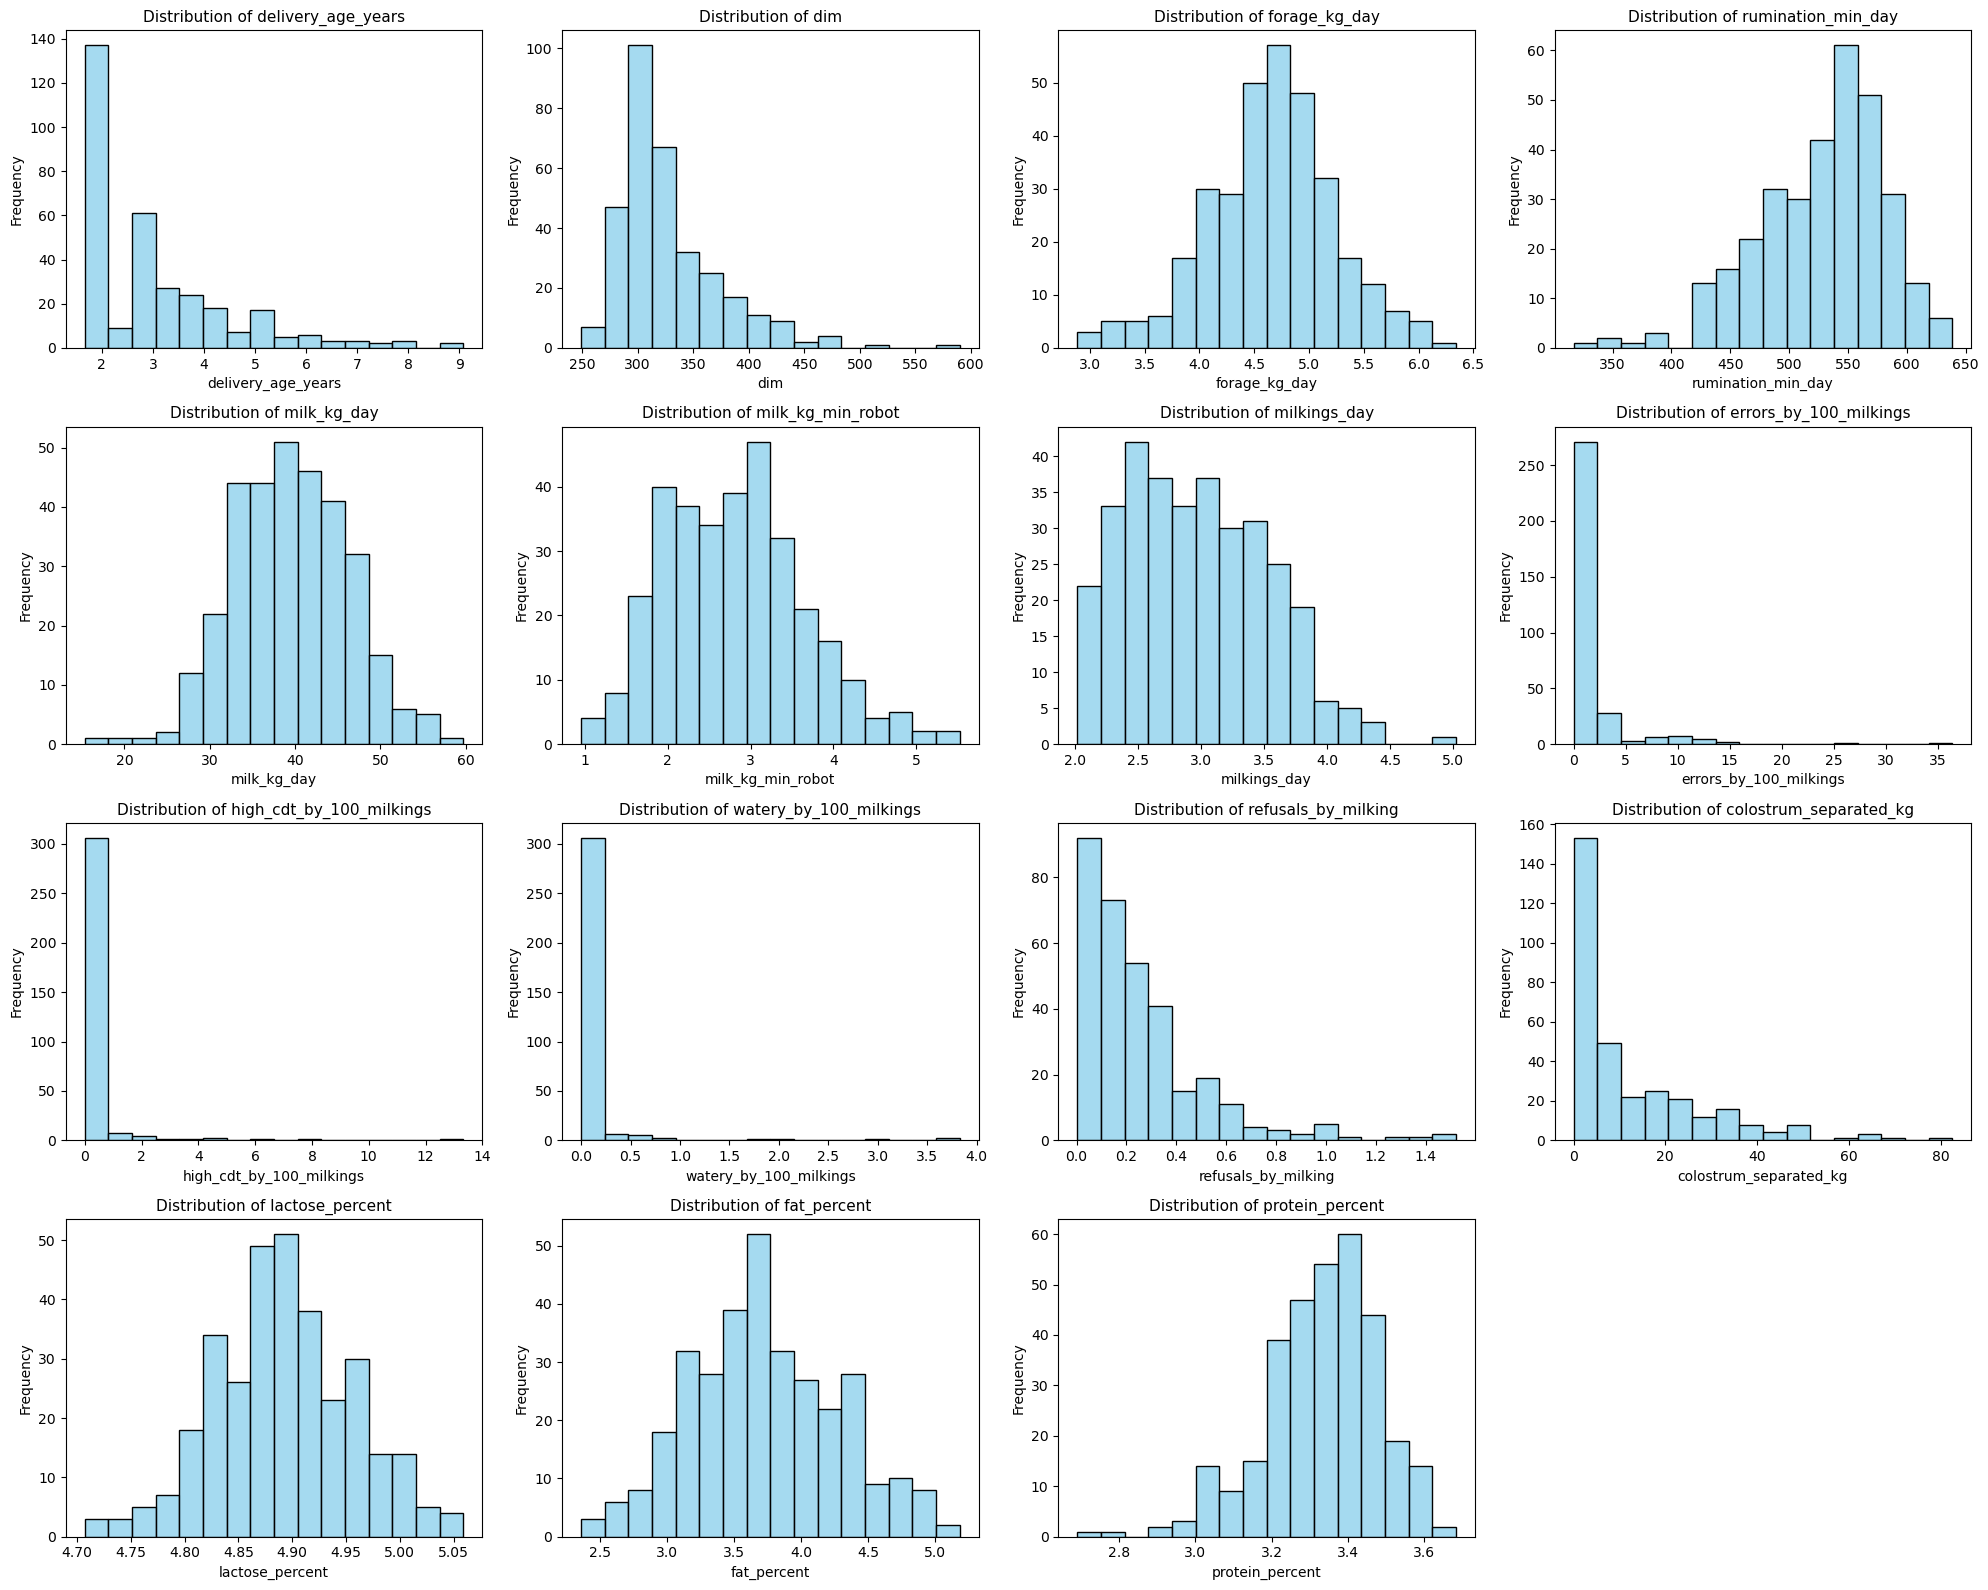

In [20]:
columns_to_plot = [col for col in data.columns if not col.startswith('lactation_')]

num_columns = len(columns_to_plot)
n_rows = 4
n_cols = 4

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 16))
axes = axes.flatten()

for i, column in enumerate(columns_to_plot):
    sns.histplot(data[column], bins=16, kde=False, color='skyblue', ax=axes[i], edgecolor='black')
    axes[i].set_title(f'Distribution of {column}', fontsize=11)
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequency')

for j in range(i+1, n_rows*n_cols):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### We proceeded on using KFOLD and saving the data in the right format to be used on models

In [21]:
X = data.drop(columns=["fat_percent", "lactose_percent", "protein_percent"])
y_fat = data["fat_percent"]
y_lactose = data["lactose_percent"]
y_protein = data["protein_percent"]

In [22]:
k = 5  
#Initialize de kfold with k 5.
kf = KFold(n_splits=k, shuffle=True, random_state=42)

scaler = StandardScaler()

X_train_kf, X_val_kf = [], []
y_fat_train_kf, y_fat_val_kf = [], []
y_lactose_train_kf, y_lactose_val_kf = [], []
y_protein_train_kf, y_protein_val_kf = [], []
 
#Kf split into the train and and test data will be 5 times. which is why there is an array 
# Like X_train_kf which will be [[],[],[],[],[]] each [] have the train data. split by k fold
for train_index, val_index in kf.split(X):
    X_train_fold, X_val_fold = X.iloc[train_index], X.iloc[val_index]
    y_fat_train_fold, y_fat_val_fold = y_fat.iloc[train_index], y_fat.iloc[val_index]
    y_lactose_train_fold, y_lactose_val_fold = y_lactose.iloc[train_index], y_lactose.iloc[val_index]
    y_protein_train_fold, y_protein_val_fold = y_protein.iloc[train_index], y_protein.iloc[val_index]

    # Scaler
    X_train_fold_scaled = scaler.fit_transform(X_train_fold)
    X_val_fold_scaled = scaler.transform(X_val_fold)

    # Convert to PyTorch tensors
    X_train_fold_tensor = torch.tensor(X_train_fold_scaled, dtype=torch.float32)
    X_val_fold_tensor = torch.tensor(X_val_fold_scaled, dtype=torch.float32)
    y_fat_train_fold_tensor = torch.tensor(y_fat_train_fold.to_numpy(), dtype=torch.float32)
    y_fat_val_fold_tensor = torch.tensor(y_fat_val_fold.to_numpy(), dtype=torch.float32)
    y_lactose_train_fold_tensor = torch.tensor(y_lactose_train_fold.to_numpy(), dtype=torch.float32)
    y_lactose_val_fold_tensor = torch.tensor(y_lactose_val_fold.to_numpy(), dtype=torch.float32)
    y_protein_train_fold_tensor = torch.tensor(y_protein_train_fold.to_numpy(), dtype=torch.float32)
    y_protein_val_fold_tensor = torch.tensor(y_protein_val_fold.to_numpy(), dtype=torch.float32)

    # Append to lists
    X_train_kf.append(X_train_fold_tensor)
    X_val_kf.append(X_val_fold_tensor)
    y_fat_train_kf.append(y_fat_train_fold_tensor)
    y_fat_val_kf.append(y_fat_val_fold_tensor)
    y_lactose_train_kf.append(y_lactose_train_fold_tensor)
    y_lactose_val_kf.append(y_lactose_val_fold_tensor)
    y_protein_train_kf.append(y_protein_train_fold_tensor)
    y_protein_val_kf.append(y_protein_val_fold_tensor)

# Linear Regression

In [23]:
# Initialize lists to store RMSE values 
rmse_fat_list = []
rmse_lactose_list = []
rmse_protein_list = []

# Perform 3 runs with different parameters
for run in range(3):
    fit_intercept = run % 2 == 0  # Alternate between True and False
    
    for i in range(k):
        # Extract and scale data for the current fold
        X_train_fold_scaled = X_train_kf[i].numpy()
        X_val_fold_scaled = X_val_kf[i].numpy()
        
        y_fat_train_fold = y_fat_train_kf[i].numpy().reshape(-1)
        y_fat_val_fold = y_fat_val_kf[i].numpy().reshape(-1)
        
        linear_model_fat = LinearRegression(fit_intercept=fit_intercept)
        linear_model_fat.fit(X_train_fold_scaled, y_fat_train_fold)
        y_pred_fat = linear_model_fat.predict(X_val_fold_scaled)
        rmse_fat = np.sqrt(mean_squared_error(y_fat_val_fold, y_pred_fat))
        rmse_fat_list.append(rmse_fat)
        
        y_lactose_train_fold = y_lactose_train_kf[i].numpy().reshape(-1)
        y_lactose_val_fold = y_lactose_val_kf[i].numpy().reshape(-1)
        
        linear_model_lactose = LinearRegression(fit_intercept=fit_intercept)
        linear_model_lactose.fit(X_train_fold_scaled, y_lactose_train_fold)
        y_pred_lactose = linear_model_lactose.predict(X_val_fold_scaled)
        rmse_lactose = np.sqrt(mean_squared_error(y_lactose_val_fold, y_pred_lactose))
        rmse_lactose_list.append(rmse_lactose)
        
        y_protein_train_fold = y_protein_train_kf[i].numpy().reshape(-1)
        y_protein_val_fold = y_protein_val_kf[i].numpy().reshape(-1)
        
        linear_model_protein = LinearRegression(fit_intercept=fit_intercept)
        linear_model_protein.fit(X_train_fold_scaled, y_protein_train_fold)
        y_pred_protein = linear_model_protein.predict(X_val_fold_scaled)
        rmse_protein = np.sqrt(mean_squared_error(y_protein_val_fold, y_pred_protein))
        rmse_protein_list.append(rmse_protein)

# Display the list of RMSE values we tried this to check for possible results
print("RMSE values for fat percent:", rmse_fat_list)
print("RMSE values for lactose percent:", rmse_lactose_list)
print("RMSE values for protein percent:", rmse_protein_list)

RMSE values for fat percent: [0.48618382, 0.49528623, 0.47511432, 0.53654087, 0.6038994, 3.7017636, 3.783577, 3.8097258, 3.7931583, 3.7342486, 0.48618382, 0.49528623, 0.47511432, 0.53654087, 0.6038994]
RMSE values for lactose percent: [0.0569433, 0.062778816, 0.054935526, 0.059664045, 0.06234355, 4.888228, 4.904656, 4.8897386, 4.8929334, 4.8906035, 0.0569433, 0.062778816, 0.054935526, 0.059664045, 0.06234355]
RMSE values for protein percent: [0.15813173, 0.16956238, 0.1266089, 0.12252656, 0.13602678, 3.3277473, 3.3205848, 3.3447835, 3.3564103, 3.3257926, 0.15813173, 0.16956238, 0.1266089, 0.12252656, 0.13602678]


# NEURAL NETWORK

In [24]:
#Initialize the function to convert the data we would work on.
def dataloaders(X_train_kf, X_val_kf, y_train_kf, y_val_kf, batch_sizes):
    train_data = []
    val_data = []

    for i in range(len(X_train_kf)):
        train_ds = TensorDataset(X_train_kf[i], y_train_kf[i])
        val_ds = TensorDataset(X_val_kf[i], y_val_kf[i])

        batch_size_GD = batch_sizes['GD']
        batch_size_SGD = batch_sizes['SGD']
        batch_size_MiniSGD = batch_sizes['MiniSGD']
        batch_size_ASGD = batch_sizes['ASGD']
        batch_size_RMSprop = batch_sizes['RMSprop']

        train_dl_GD = DataLoader(train_ds, batch_size_GD, shuffle=True)
        val_dl_GD = DataLoader(val_ds, batch_size_GD, shuffle=True)
        train_dl_SGD = DataLoader(train_ds, batch_size_SGD, shuffle=True)
        val_dl_SGD = DataLoader(val_ds, batch_size_SGD, shuffle=True)
        train_dl_MiniSGD = DataLoader(train_ds, batch_size_MiniSGD, shuffle=True)
        val_dl_MiniSGD = DataLoader(val_ds, batch_size_MiniSGD, shuffle=True)
        train_dl_ASGD = DataLoader(train_ds, batch_size_ASGD, shuffle=True)
        val_dl_ASGD = DataLoader(val_ds, batch_size_ASGD, shuffle=True)
        train_dl_RMSprop = DataLoader(train_ds, batch_size_RMSprop, shuffle=True)
        val_dl_RMSprop = DataLoader(val_ds, batch_size_RMSprop, shuffle=True)
        
        train_data.append({
            'GD': train_dl_GD,
            'SGD': train_dl_SGD,
            'MiniSGD': train_dl_MiniSGD,
            'ASGD': train_dl_ASGD,
            'RMSprop': train_dl_RMSprop
        })

        val_data.append({
            'GD': val_dl_GD,
            'SGD': val_dl_SGD,
            'MiniSGD': val_dl_MiniSGD,
            'ASGD': val_dl_ASGD,
            'RMSprop': val_dl_RMSprop
        })

    return train_data, val_data

# Define batch sizes for each optimizer
batch_sizes = {
    'GD': X_train_kf[0].shape[0],
    'SGD': 1,
    'MiniSGD': 32,
    'ASGD': 64,
    'RMSprop': 128
}

# Get dataloaders for each percentage
fat_train_data, fat_val_data = dataloaders(X_train_kf, X_val_kf, y_fat_train_kf, y_fat_val_kf, batch_sizes)
lactose_train_data, lactose_val_data = dataloaders(X_train_kf, X_val_kf, y_lactose_train_kf, y_lactose_val_kf, batch_sizes)
protein_train_data, protein_val_data = dataloaders(X_train_kf, X_val_kf, y_protein_train_kf, y_protein_val_kf, batch_sizes)

In [25]:
#The neural network we would work on.
class Net(nn.Module):
    def __init__(self, input_dim):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(16, 1)
        self.activation = nn.ReLU()
        self.apply(self._init_weights)
    
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.xavier_uniform_(module.weight)
            nn.init.zeros_(module.bias)
    
    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.activation(self.fc3(x))
        x = torch.sigmoid(self.fc4(x))
        return x

    def train_model(self, num_epochs, loss_fn, optimizer, train_dl, val_dl, train_size, val_size, batch_size):
        self.apply(self._init_weights)
        loss_hist_train = [0] * num_epochs
        rmse_hist_train = [0] * num_epochs
        loss_hist_valid = [0] * num_epochs
        rmse_hist_valid = [0] * num_epochs

        for epoch in tqdm(range(num_epochs)):
            epoch_train_loss = 0
            train_predictions = []
            train_targets = []
            self.train()
            for x_batch, y_batch in train_dl:
                pred = self(x_batch)
                loss = loss_fn(pred, y_batch)
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
                epoch_train_loss += loss.item()
                train_predictions.append(pred.detach().cpu().numpy())
                train_targets.append(y_batch.detach().cpu().numpy())

            train_predictions = np.concatenate(train_predictions)
            train_targets = np.concatenate(train_targets)
            loss_hist_train[epoch] = epoch_train_loss / (train_size / batch_size)
            rmse_hist_train[epoch] = compute_rmse(train_predictions, train_targets)

            self.eval()
            with torch.no_grad():
                val_predictions = []
                val_targets = []
                for x_batch, y_batch in val_dl:
                    pred = self(x_batch)
                    val_predictions.append(pred.detach().cpu().numpy())
                    val_targets.append(y_batch.detach().cpu().numpy())

                val_predictions = np.concatenate(val_predictions)
                val_targets = np.concatenate(val_targets)
                valid_loss = loss_fn(torch.tensor(val_predictions), torch.tensor(val_targets)).item()
                loss_hist_valid[epoch] = valid_loss
                rmse_hist_valid[epoch] = compute_rmse(val_predictions, val_targets)

        return loss_hist_train, loss_hist_valid, rmse_hist_train, rmse_hist_valid


# Function to compute RMSE
def compute_rmse(predictions, targets):
    return np.sqrt(np.mean((predictions - targets) ** 2))

def train_and_evaluate_kfold(model, optimizer, num_epochs, loss_fn, X_kf, y_kf):
    history = {}

    for fold_idx, ((X_train_fold, X_val_fold), (y_train_fold, y_val_fold)) in enumerate(zip(X_kf, y_kf)):
        print(f"Training models for fold {fold_idx + 1}...")
        train_ds = TensorDataset(X_train_fold, y_train_fold)
        val_ds = TensorDataset(X_val_fold, y_val_fold)

        train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
        val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

        model_instance = model(input_dim=X_train_fold.shape[1])
        optimizer_instance = optimizer(model_instance.parameters(), lr=learning_rate)

        history_fold = model_instance.train_model(
            num_epochs=num_epochs,
            loss_fn=loss_fn,
            optimizer=optimizer_instance,
            train_dl=train_dl,
            val_dl=val_dl,
            train_size=len(train_dl.dataset),
            val_size=len(val_dl.dataset),
            batch_size=batch_size
        )

        history[f'Fold_{fold_idx + 1}'] = history_fold

    return history

# neural networks for each target variable
input_dim = X_train_fold.shape[1]
nn_names = ['GD', 'SGD', 'MiniSGD', 'ASGD', 'RMSprop']
nn_torch = {k: Net(input_dim) for k in nn_names}

# Define loss function
loss_fn = nn.MSELoss()

# Define learning rates
learning_rates = {
    'GD': 0.05,
    'SGD': 0.05,
    'MiniSGD': 0.05,
    'ASGD': 0.05,
    'RMSprop': 0.05
}

# Define optimizers
optimizers = {
    'GD': torch.optim.SGD,
    'SGD': torch.optim.SGD,
    'MiniSGD': torch.optim.SGD,
    'ASGD': torch.optim.ASGD,
    'RMSprop': torch.optim.RMSprop
}
num_epochs = 12

In [26]:
#Preparing the functions we would use to kfold and get data.
def prepare_kfold_data(X, y, k):
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    scaler = StandardScaler()

    X_kf, y_kf = [], []
    for train_index, val_index in kf.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)

        X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
        X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train.to_numpy(), dtype=torch.float32).view(-1, 1)
        y_val_tensor = torch.tensor(y_val.to_numpy(), dtype=torch.float32).view(-1, 1)

        X_kf.append((X_train_tensor, X_val_tensor))
        y_kf.append((y_train_tensor, y_val_tensor))

    return X_kf, y_kf

def train_and_evaluate_kfold(models, optimizers, num_epochs, loss_fn, X_kf, y_kf, batch_sizes, learning_rates):
    history = {}

    for nn_name, model in models.items():
        optimizer = optimizers[nn_name]
        history_nn = {}
        for fold_idx, ((X_train_fold, X_val_fold), (y_train_fold, y_val_fold)) in enumerate(zip(X_kf, y_kf)):
            print(f"Training {nn_name} for fold {fold_idx + 1}...")
            train_ds = TensorDataset(X_train_fold, y_train_fold)
            val_ds = TensorDataset(X_val_fold, y_val_fold)

            # Retrieve the batch size for the current optimizer
            batch_size = batch_sizes[nn_name]

            train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
            val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

            optimizer_instance = optimizer(model.parameters(), lr=learning_rates[nn_name])

            history_fold = model.train_model(
                num_epochs=num_epochs,
                loss_fn=loss_fn,
                optimizer=optimizer_instance,
                train_dl=train_dl,
                val_dl=val_dl,
                train_size=len(train_dl.dataset),
                val_size=len(val_dl.dataset),
                batch_size=batch_size  # Use the retrieved batch size
            )

            print(f"Fold {fold_idx + 1} history for {nn_name}: {history_fold}")  # Debug print

            history_nn[f'Fold_{fold_idx + 1}'] = history_fold

        history[nn_name] = history_nn

    return history

def compute_average_history(history):
    avg_history = {}

    for nn_name, folds_history in history.items():
        
        first_fold_metrics = folds_history[list(folds_history.keys())[0]]
        num_metrics = len(first_fold_metrics)  # Determine the number of metrics
        
        # Initialize avg_history_nn 
        avg_history_nn = {f'metric_{i}': [] for i in range(num_metrics)}

        for fold_name, metrics in folds_history.items():
            #print(f"Fold {fold_name} metrics for {nn_name}: {metrics}") 

            for i, values in enumerate(metrics):
                key = f'metric_{i}'
                for epoch in range(len(values)):
                    if len(avg_history_nn[key]) <= epoch:
                        avg_history_nn[key].append(0)
                    avg_history_nn[key][epoch] += values[epoch]

        num_folds = len(folds_history)
        for key in avg_history_nn:
            avg_history_nn[key] = [value / num_folds for value in avg_history_nn[key]]
        
        avg_history[nn_name] = avg_history_nn

    return avg_history

#Obtain the data to evaluate and then compute it in neural to get a value. 
X_fat_kf, y_fat_kf = prepare_kfold_data(X, y_fat, k)
X_lactose_kf, y_lactose_kf = prepare_kfold_data(X, y_lactose, k)
X_protein_kf, y_protein_kf = prepare_kfold_data(X, y_protein, k)

# Call the function with the parameters
history_kfold_fat = train_and_evaluate_kfold(nn_torch, optimizers, num_epochs, loss_fn, X_fat_kf, y_fat_kf, batch_sizes, learning_rates)
history_kfold_lactose = train_and_evaluate_kfold(nn_torch, optimizers, num_epochs, loss_fn, X_lactose_kf, y_lactose_kf, batch_sizes, learning_rates)
history_kfold_protein = train_and_evaluate_kfold(nn_torch, optimizers, num_epochs, loss_fn, X_protein_kf, y_protein_kf, batch_sizes, learning_rates)

# Compute average histories
avg_history_fat = compute_average_history(history_kfold_fat)
avg_history_lactose = compute_average_history(history_kfold_lactose)
avg_history_protein = compute_average_history(history_kfold_protein)



Training GD for fold 1...


100%|██████████| 12/12 [00:00<00:00, 63.74it/s]


Fold 1 history for GD: ([10.894536018371582, 10.429581642150879, 10.007054328918457, 9.594786643981934, 9.199703216552734, 8.845125198364258, 8.559062957763672, 8.346874237060547, 8.198348999023438, 8.095802307128906, 8.024731636047363, 7.974510192871094], [10.160636901855469, 9.741962432861328, 9.330543518066406, 8.939003944396973, 8.590193748474121, 8.314321517944336, 8.113980293273926, 7.977512836456299, 7.885343074798584, 7.822479248046875, 7.7788801193237305, 7.747608184814453], [3.3006873, 3.2294862, 3.1633928, 3.0975451, 3.0331013, 2.9740756, 2.9255877, 2.8890958, 2.863276, 2.8453124, 2.8327956, 2.8239174], [3.1875753, 3.1212118, 3.0545938, 2.9898171, 2.9309032, 2.8834565, 2.848505, 2.824449, 2.8080852, 2.7968695, 2.7890644, 2.7834527])
Training GD for fold 2...


100%|██████████| 12/12 [00:00<00:00, 108.46it/s]


Fold 2 history for GD: ([10.799033164978027, 10.225319862365723, 9.7251615524292, 9.263681411743164, 8.86915111541748, 8.547517776489258, 8.303096771240234, 8.126625061035156, 8.002242088317871, 7.914742946624756, 7.852419853210449, 7.807409763336182], [10.952652931213379, 10.395751953125, 9.89439582824707, 9.472738265991211, 9.136878967285156, 8.89041805267334, 8.715577125549316, 8.59259033203125, 8.50721549987793, 8.446843147277832, 8.403106689453125, 8.370847702026367], [3.2861881, 3.197705, 3.118519, 3.0436294, 2.9781122, 2.9236138, 2.8815095, 2.8507235, 2.8288233, 2.8133152, 2.802217, 2.7941742], [3.309479, 3.2242444, 3.145536, 3.0777814, 3.022727, 2.9816804, 2.952216, 2.931312, 2.9167132, 2.9063454, 2.898811, 2.8932416])
Training GD for fold 3...


100%|██████████| 12/12 [00:00<00:00, 189.41it/s]


Fold 3 history for GD: ([10.776556015014648, 10.371240615844727, 10.012253761291504, 9.67011547088623, 9.334092140197754, 9.014508247375488, 8.726943969726562, 8.488380432128906, 8.304076194763184, 8.169261932373047, 8.071674346923828, 8.001142501831055], [10.471647262573242, 10.091910362243652, 9.736712455749512, 9.39283561706543, 9.068310737609863, 8.77635669708252, 8.535619735717773, 8.348471641540527, 8.211368560791016, 8.112545013427734, 8.041404724121094, 7.989547252655029], [3.2827666, 3.220441, 3.1642146, 3.1096811, 3.0551746, 3.002417, 2.95414, 2.9134824, 2.8816795, 2.858192, 2.8410695, 2.828629], [3.2359924, 3.1767766, 3.1203706, 3.0647736, 3.0113635, 2.9624918, 2.9215782, 2.889372, 2.8655486, 2.8482528, 2.835737, 2.8265789])
Training GD for fold 4...


100%|██████████| 12/12 [00:00<00:00, 156.33it/s]


Fold 4 history for GD: ([10.675066947937012, 10.14855670928955, 9.69565486907959, 9.279889106750488, 8.912640571594238, 8.61571216583252, 8.390321731567383, 8.225751876831055, 8.107364654541016, 8.02281379699707, 7.9616546630859375, 7.916181564331055], [10.287209510803223, 9.8509521484375, 9.446170806884766, 9.085393905639648, 8.791205406188965, 8.567593574523926, 8.402606010437012, 8.282432556152344, 8.19546890258789, 8.131377220153809, 8.083474159240723, 8.047004699707031], [3.267272, 3.18568, 3.1137846, 3.046291, 2.9854045, 2.9352534, 2.8966053, 2.868057, 2.8473434, 2.8324573, 2.8216405, 2.813571], [3.207368, 3.1386228, 3.0734622, 3.0141988, 2.9649966, 2.927045, 2.8987248, 2.8779216, 2.862773, 2.851557, 2.8431451, 2.8367243])
Training GD for fold 5...


100%|██████████| 12/12 [00:00<00:00, 138.92it/s]


Fold 5 history for GD: ([19.337880618755634, 14.85035942884592, 22.87598447432885, 19.586443127118624, 18.337623695226817, 13.549076371926528, 17.239297617398776, 22.233953090814445, 17.23853286229647, 19.57517320192777, 14.360545185896067, 16.463468291209296], [8.191825866699219, 7.671477794647217, 7.460774898529053, 7.352837085723877, 7.303549289703369, 7.283090591430664, 7.275369644165039, 7.2628045082092285, 7.254251480102539, 7.251539707183838, 7.249007701873779, 7.24556827545166], [3.1820056, 2.983007, 2.8861701, 2.8462446, 2.8271806, 2.8187392, 2.8151953, 2.8137605, 2.811719, 2.8102195, 2.8097157, 2.8092482], [2.8621364, 2.7697434, 2.731442, 2.7116115, 2.702508, 2.6987202, 2.6972892, 2.6949592, 2.6933718, 2.6928685, 2.6923983, 2.691759])
Training SGD for fold 1...


100%|██████████| 12/12 [00:00<00:00, 23.61it/s]


Fold 1 history for SGD: ([7.824959935368718, 7.767562504900929, 7.767199416418333, 7.767066363202098, 7.766998309426326, 7.766957194648654, 7.766929866724493, 7.76691054837584, 7.766896107482173, 7.7668849220607274, 7.766876140616575, 7.766868944794055], [7.611242771148682, 7.610694408416748, 7.61053466796875, 7.61046028137207, 7.610419273376465, 7.6103925704956055, 7.610372543334961, 7.610360145568848, 7.610349655151367, 7.6103410720825195, 7.610334873199463, 7.610329627990723], [2.797313, 2.7870345, 2.7869694, 2.7869458, 2.7869337, 2.786926, 2.7869213, 2.7869177, 2.7869153, 2.7869132, 2.7869115, 2.7869103], [2.758848, 2.7587488, 2.7587197, 2.7587063, 2.7586987, 2.758694, 2.7586904, 2.7586882, 2.758686, 2.7586846, 2.7586837, 2.7586827])
Training SGD for fold 2...


100%|██████████| 12/12 [00:00<00:00, 24.09it/s]


Fold 2 history for SGD: ([7.652235688850226, 7.6155653045904685, 7.615211624896665, 7.615079761471987, 7.615011758325643, 7.614970523878414, 7.614943001261089, 7.614923560941541, 7.614908991633235, 7.61489775005915, 7.6148888029186885, 7.614881581321186], [8.216948509216309, 8.216355323791504, 8.216179847717285, 8.216096878051758, 8.21605110168457, 8.216021537780762, 8.2160005569458, 8.215985298156738, 8.215973854064941, 8.215965270996094, 8.215958595275879, 8.215951919555664], [2.7662675, 2.7596314, 2.7595673, 2.7595434, 2.759531, 2.7595236, 2.7595186, 2.759515, 2.7595124, 2.7595105, 2.7595088, 2.7595077], [2.866522, 2.8664186, 2.8663878, 2.8663735, 2.8663654, 2.8663604, 2.8663566, 2.866354, 2.866352, 2.8663507, 2.8663492, 2.8663483])
Training SGD for fold 3...


100%|██████████| 12/12 [00:00<00:00, 24.10it/s]


Fold 3 history for SGD: ([7.774760782028257, 7.72812954799549, 7.727788784329035, 7.727661982466355, 7.72759653702666, 7.727557093940646, 7.727530778605045, 7.7275121580219635, 7.72749832698277, 7.727487553040493, 7.727478972733251, 7.727472062276597], [7.768308639526367, 7.767714500427246, 7.767538547515869, 7.7674560546875, 7.767409801483154, 7.767379283905029, 7.767357349395752, 7.767343044281006, 7.767331123352051, 7.767322540283203, 7.76731538772583, 7.767309188842773], [2.7883258, 2.7799513, 2.77989, 2.7798674, 2.7798555, 2.7798483, 2.7798438, 2.7798402, 2.7798378, 2.779836, 2.7798343, 2.779833], [2.7871687, 2.7870622, 2.7870302, 2.7870157, 2.787007, 2.7870018, 2.786998, 2.7869954, 2.7869933, 2.7869916, 2.7869904, 2.7869892])
Training SGD for fold 4...


100%|██████████| 12/12 [00:00<00:00, 23.01it/s]


Fold 4 history for SGD: ([7.776339906983394, 7.706099780830177, 7.705706170627049, 7.705563076674708, 7.705490335994706, 7.705446609198817, 7.705417641341456, 7.705397164959705, 7.705381957260338, 7.705370246213375, 7.705361004501697, 7.705353506743678], [7.856762886047363, 7.856018543243408, 7.855793476104736, 7.855687141418457, 7.855625152587891, 7.855585098266602, 7.855557441711426, 7.8555378913879395, 7.855521202087402, 7.855508804321289, 7.855498790740967, 7.855490684509277], [2.788609, 2.7759862, 2.7759154, 2.7758896, 2.7758765, 2.7758687, 2.7758634, 2.7758598, 2.775857, 2.7758548, 2.7758532, 2.7758517], [2.8029919, 2.8028588, 2.8028188, 2.8028, 2.8027887, 2.8027818, 2.8027768, 2.8027732, 2.8027701, 2.8027682, 2.8027663, 2.8027647])
Training SGD for fold 5...


100%|██████████| 12/12 [00:00<00:00, 23.37it/s]


Fold 5 history for SGD: ([7.9597599992385275, 7.863098598902042, 7.862673186338865, 7.862516290407914, 7.862436039631183, 7.862387647995582, 7.862355505503141, 7.862332729651378, 7.862315801015267, 7.862302747139564, 7.862292384642821, 7.862283930411706], [7.222045421600342, 7.221077919006348, 7.220775604248047, 7.220632076263428, 7.220549583435059, 7.220495223999023, 7.220457553863525, 7.220428943634033, 7.220407485961914, 7.220391273498535, 7.220376968383789, 7.220366477966309], [2.8213048, 2.8041217, 2.804046, 2.8040178, 2.8040037, 2.803995, 2.8039892, 2.803985, 2.8039823, 2.8039799, 2.803978, 2.8039763], [2.6873865, 2.6872063, 2.68715, 2.6871235, 2.687108, 2.687098, 2.6870909, 2.6870856, 2.6870816, 2.6870785, 2.6870759, 2.687074])
Training MiniSGD for fold 1...


100%|██████████| 12/12 [00:00<00:00, 421.30it/s]


Fold 1 history for MiniSGD: ([10.281343614732897, 9.149705452348275, 9.073123121813918, 8.404521102610703, 8.762097686414092, 8.66420383527012, 9.082121683363749, 8.79805039807176, 8.803375951111548, 8.643720825666627, 8.684295477554144, 8.368377390975658], [7.873002052307129, 7.6714582443237305, 7.638408660888672, 7.627559661865234, 7.622323036193848, 7.619491100311279, 7.617746829986572, 7.616461753845215, 7.61549711227417, 7.614826202392578, 7.614289283752441, 7.613858222961426], [3.0670142, 2.8145654, 2.7957888, 2.7915194, 2.789921, 2.7890742, 2.7886019, 2.7883036, 2.7880778, 2.7879052, 2.7877839, 2.787685], [2.805887, 2.7697396, 2.7637672, 2.7618039, 2.7608557, 2.7603426, 2.7600267, 2.7597938, 2.759619, 2.7594974, 2.7594001, 2.7593222])
Training MiniSGD for fold 2...


100%|██████████| 12/12 [00:00<00:00, 424.95it/s]


Fold 2 history for MiniSGD: ([9.766305164941029, 8.705789337747346, 8.257465259448901, 8.355196448366614, 8.50123878979775, 8.40429098357565, 8.407980075674168, 8.4734438156069, 8.492375200779742, 8.689027940904772, 8.65389755425766, 8.607139793602196], [8.360698699951172, 8.258526802062988, 8.23962116241455, 8.23104476928711, 8.227035522460938, 8.224453926086426, 8.222830772399902, 8.221700668334961, 8.220766067504883, 8.220126152038574, 8.219627380371094, 8.219189643859863], [2.9625497, 2.7766817, 2.7658963, 2.763329, 2.7620502, 2.7614155, 2.7609932, 2.7607212, 2.7605271, 2.7603652, 2.7602534, 2.7601655], [2.8914874, 2.8737652, 2.870474, 2.8689797, 2.868281, 2.867831, 2.8675478, 2.8673508, 2.867188, 2.8670762, 2.8669894, 2.8669128])
Training MiniSGD for fold 3...


100%|██████████| 12/12 [00:00<00:00, 428.34it/s]


Fold 3 history for MiniSGD: ([10.713185726445614, 9.02895199101864, 8.6880285196783, 8.427846547719595, 8.49926604635467, 8.63086732842287, 8.8709757447703, 8.203913036920849, 8.263707105717604, 8.383965157173776, 8.56867197397593, 8.353029170091547], [8.149490356445312, 7.856273651123047, 7.807577133178711, 7.792373180389404, 7.785252094268799, 7.780693054199219, 7.777783393859863, 7.775965690612793, 7.774624347686768, 7.773651123046875, 7.772903919219971, 7.772302150726318], [3.1190968, 2.812333, 2.7896283, 2.784748, 2.7830148, 2.7821593, 2.781593, 2.7812233, 2.7809885, 2.7808127, 2.7806845, 2.780585], [2.8547313, 2.8029046, 2.7942042, 2.7914822, 2.7902064, 2.7893894, 2.788868, 2.7885418, 2.7883012, 2.7881267, 2.787993, 2.7878847])
Training MiniSGD for fold 4...


100%|██████████| 12/12 [00:00<00:00, 435.93it/s]


Fold 4 history for MiniSGD: ([10.085956293643672, 8.75758238096495, 8.746155492127173, 8.710827566021658, 8.512746332234858, 8.444297466499005, 8.589710898380943, 8.752743106090884, 8.465014542391861, 8.676182573826617, 8.485561473949536, 8.586393614073057], [8.17998218536377, 7.937519550323486, 7.894059658050537, 7.8785247802734375, 7.872021675109863, 7.868256092071533, 7.865753650665283, 7.864014625549316, 7.8627238273620605, 7.8617658615112305, 7.8610005378723145, 7.860342979431152], [3.0511222, 2.8073382, 2.7860148, 2.7810493, 2.7790778, 2.7782109, 2.7776976, 2.7773476, 2.777102, 2.7769167, 2.7767785, 2.7766664], [2.8600667, 2.8173604, 2.809637, 2.8068712, 2.8057122, 2.805041, 2.804595, 2.804285, 2.8040547, 2.8038843, 2.8037477, 2.8036304])
Training MiniSGD for fold 5...


100%|██████████| 12/12 [00:00<00:00, 444.92it/s]


Fold 5 history for MiniSGD: ([10.481119948167068, 8.700250948392428, 8.778792278583234, 8.744422032282902, 8.672719984788161, 8.74356442964994, 8.812890390249398, 8.381600717397836, 9.035069803091195, 9.118461432823768, 8.575575667161209, 8.704653695913462], [7.581460952758789, 7.305293083190918, 7.260447025299072, 7.244344234466553, 7.236957550048828, 7.232697010040283, 7.230106830596924, 7.228446006774902, 7.227122783660889, 7.226150035858154, 7.225451469421387, 7.224889278411865], [3.087688, 2.8374615, 2.8143313, 2.8093834, 2.8073711, 2.8063912, 2.8058016, 2.8054328, 2.8051925, 2.8049986, 2.804856, 2.8047519], [2.7534454, 2.7028306, 2.6945217, 2.6915321, 2.6901596, 2.6893673, 2.6888857, 2.688577, 2.6883307, 2.68815, 2.68802, 2.6879153])
Training ASGD for fold 1...


100%|██████████| 12/12 [00:00<00:00, 432.67it/s]


Fold 1 history for ASGD: ([12.05377703928119, 10.437656004916747, 10.019512515270572, 9.460496350144787, 9.569281265082047, 9.961519572725628, 9.195669991629464, 9.295031808978342, 10.043419561791143, 9.716515736230091, 9.850627295298926, 8.934341607406793], [8.409931182861328, 7.803579330444336, 7.688590049743652, 7.654036045074463, 7.639135360717773, 7.631304740905762, 7.6269378662109375, 7.623207092285156, 7.62109375, 7.619550704956055, 7.618144512176514, 7.617099285125732], [3.194427, 2.8979988, 2.8206332, 2.8026233, 2.7963965, 2.793485, 2.7918706, 2.7909276, 2.7901037, 2.7896237, 2.7892642, 2.7889347], [2.8999882, 2.7934887, 2.7728307, 2.7665927, 2.7638988, 2.7624815, 2.761691, 2.7610157, 2.7606328, 2.7603536, 2.7600987, 2.7599094])
Training ASGD for fold 2...


100%|██████████| 12/12 [00:00<00:00, 474.91it/s]


Fold 2 history for ASGD: ([12.445378483952704, 10.393585676392073, 9.346701721427063, 9.007571422915662, 9.65651393581081, 9.140250187582952, 9.449013964089648, 8.728022866267494, 9.258457964451617, 9.290362383868244, 8.964913622292773, 9.509502867474058], [9.019936561584473, 8.439396858215332, 8.31875228881836, 8.271728515625, 8.256656646728516, 8.247343063354492, 8.241223335266113, 8.236742973327637, 8.2333984375, 8.231425285339355, 8.229631423950195, 8.228302001953125], [3.13663, 2.8550575, 2.7888827, 2.7736282, 2.7673934, 2.7652783, 2.763947, 2.7630548, 2.7623985, 2.7619197, 2.761635, 2.7613778], [3.003321, 2.905064, 2.8842247, 2.8760614, 2.87344, 2.8718188, 2.870753, 2.8699725, 2.86939, 2.8690462, 2.8687334, 2.8685017])
Training ASGD for fold 3...


100%|██████████| 12/12 [00:00<00:00, 476.45it/s]


Fold 3 history for ASGD: ([11.368120819445283, 9.684674708539454, 9.60251773554386, 9.31120895326828, 9.05432635568744, 10.4992232746139, 9.75624231758265, 9.567713203577462, 9.698314416362512, 9.403847830636161, 10.13018292165631, 9.42277344221314], [8.464336395263672, 7.982323169708252, 7.859962463378906, 7.821692943572998, 7.8035125732421875, 7.794594764709473, 7.786962985992432, 7.783147811889648, 7.780862331390381, 7.779052734375, 7.7774977684021, 7.776383876800537], [3.0863798, 2.8663168, 2.8107748, 2.7945871, 2.78898, 2.786088, 2.7846265, 2.7833357, 2.7826903, 2.7822936, 2.7819777, 2.7816997], [2.9093533, 2.8253005, 2.8035624, 2.796729, 2.7934768, 2.7918801, 2.790513, 2.7898293, 2.7894197, 2.7890952, 2.7888165, 2.7886167])
Training ASGD for fold 4...


100%|██████████| 12/12 [00:00<00:00, 475.62it/s]


Fold 4 history for ASGD: ([12.328289252910835, 9.693376813616071, 9.775806441730515, 8.733366388151545, 8.997603839888995, 9.684690261899734, 9.832439172221887, 9.484193190644607, 9.82293465514901, 9.644703986561897, 10.362633900292591, 9.638814447469233], [8.793217658996582, 8.070961952209473, 7.943441867828369, 7.90757417678833, 7.889208793640137, 7.880465030670166, 7.87450647354126, 7.871016025543213, 7.868747234344482, 7.866711616516113, 7.865261077880859, 7.864189624786377], [3.2312284, 2.888787, 2.8069284, 2.790048, 2.7847376, 2.781808, 2.7803566, 2.7793262, 2.778711, 2.778307, 2.7779417, 2.777681], [2.965336, 2.8409438, 2.8184114, 2.812041, 2.8087735, 2.8072166, 2.806155, 2.805533, 2.8051286, 2.804766, 2.8045073, 2.8043163])
Training ASGD for fold 5...


100%|██████████| 12/12 [00:00<00:00, 466.71it/s]


Fold 5 history for ASGD: ([12.077695641150841, 10.641442401592547, 9.658037743201623, 9.293207608736479, 9.547098599947416, 9.684986407940205, 9.783274371807392, 9.08281003511869, 9.578932776817908, 9.665631338266225, 9.73507831280048, 9.754232670710637], [7.742082595825195, 7.402007102966309, 7.303054332733154, 7.274213790893555, 7.259526252746582, 7.249914169311523, 7.244237899780273, 7.239973068237305, 7.236757278442383, 7.234565734863281, 7.232753276824951, 7.231179237365723], [3.1342304, 2.8648984, 2.8276932, 2.8155098, 2.811607, 2.8095732, 2.8082323, 2.8074117, 2.8067975, 2.8063288, 2.8060093, 2.8057487], [2.7824597, 2.720663, 2.7024162, 2.6970751, 2.6943507, 2.6925664, 2.691512, 2.6907198, 2.6901221, 2.6897147, 2.6893778, 2.6890852])
Training RMSprop for fold 1...


100%|██████████| 12/12 [00:00<00:00, 525.36it/s]


Fold 1 history for RMSprop: ([13.65871120143581, 11.380314536076256, 10.981599196503982, 11.9566098953306, 12.475369133083976, 12.682591972203788, 11.543842566059363, 12.713374900081442, 11.247599598063465, 10.776378734691724, 11.407236931406853, 9.96635949565637], [7.610280513763428, 7.610280513763428, 7.610280513763428, 7.610280513763428, 7.610280513763428, 7.610280513763428, 7.610280513763428, 7.610280513763428, 7.610280513763428, 7.610280513763428, 7.610280513763428, 7.610280513763428], [3.0086348, 2.7868989, 2.7868989, 2.7868989, 2.7868989, 2.7868989, 2.7868989, 2.7868989, 2.7868989, 2.7868989, 2.7868989, 2.7868989], [2.7586737, 2.7586737, 2.7586737, 2.7586737, 2.7586737, 2.7586737, 2.7586737, 2.7586737, 2.7586737, 2.7586737, 2.7586737, 2.7586737])
Training RMSprop for fold 2...


100%|██████████| 12/12 [00:00<00:00, 619.77it/s]


Fold 2 history for RMSprop: ([12.479639001794764, 10.509694692250845, 10.846367442009532, 12.437627490422901, 11.129322184559001, 10.79126565704935, 10.797103822921693, 11.851160469202462, 11.308749990573721, 10.411754004283301, 11.66175211902751, 11.035119487512066], [8.215897560119629, 8.215897560119629, 8.215897560119629, 8.215897560119629, 8.215897560119629, 8.215897560119629, 8.215897560119629, 8.215897560119629, 8.215897560119629, 8.215897560119629, 8.215897560119629, 8.215897560119629], [2.9942172, 2.7594957, 2.7594957, 2.7594957, 2.7594957, 2.7594957, 2.7594957, 2.7594957, 2.7594957, 2.7594957, 2.7594957, 2.7594957], [2.8663387, 2.8663387, 2.8663387, 2.8663387, 2.8663387, 2.8663387, 2.8663387, 2.8663387, 2.8663387, 2.8663387, 2.8663387, 2.8663387])
Training RMSprop for fold 3...


100%|██████████| 12/12 [00:00<00:00, 656.45it/s]


Fold 3 history for RMSprop: ([13.951140061308518, 11.157875326149252, 12.534336163730694, 12.046426309121621, 11.66347194362331, 12.027785135512186, 13.715687637623672, 11.523215982444498, 11.31563188118364, 10.216112055833735, 11.321360466563103, 11.402714909733954], [7.767253875732422, 7.767253875732422, 7.767253875732422, 7.767253875732422, 7.767253875732422, 7.767253875732422, 7.767253875732422, 7.767253875732422, 7.767253875732422, 7.767253875732422, 7.767253875732422, 7.767253875732422], [3.0970418, 2.779822, 2.779822, 2.779822, 2.7798219, 2.779822, 2.779822, 2.779822, 2.779822, 2.779822, 2.779822, 2.779822], [2.7869794, 2.7869794, 2.7869794, 2.7869794, 2.7869794, 2.7869794, 2.7869794, 2.7869794, 2.7869794, 2.7869794, 2.7869794, 2.7869794])
Training RMSprop for fold 4...


100%|██████████| 12/12 [00:00<00:00, 655.10it/s]


Fold 4 history for RMSprop: ([12.550586832996501, 11.715370207679777, 10.719522012246621, 12.80738200184001, 10.871801192235763, 12.12968651024071, 10.792648727829391, 9.614177453471887, 11.451318689294764, 10.512060688269184, 10.912248883928571, 10.787664347173624], [7.85540771484375, 7.85540771484375, 7.85540771484375, 7.85540771484375, 7.85540771484375, 7.85540771484375, 7.85540771484375, 7.85540771484375, 7.85540771484375, 7.85540771484375, 7.85540771484375, 7.85540771484375], [3.053141, 2.7758398, 2.77584, 2.7758398, 2.7758398, 2.7758398, 2.77584, 2.77584, 2.77584, 2.7758398, 2.77584, 2.77584], [2.80275, 2.80275, 2.80275, 2.80275, 2.80275, 2.80275, 2.80275, 2.80275, 2.80275, 2.80275, 2.80275, 2.80275])
Training RMSprop for fold 5...


100%|██████████| 12/12 [00:00<00:00, 660.50it/s]


Fold 5 history for RMSprop: ([13.790403630183294, 10.15003920335036, 12.658193734975962, 10.070066246619591, 11.606443903996395, 10.288146268404446, 11.22564204289363, 11.704976008488583, 11.674646935096154, 10.933133404071514, 10.8131350003756, 10.90115450345553], [7.220254898071289, 7.220254898071289, 7.220254898071289, 7.220254898071289, 7.220254898071289, 7.220254898071289, 7.220254898071289, 7.220254898071289, 7.220254898071289, 7.220254898071289, 7.220254898071289, 7.220254898071289], [3.0710077, 2.8039632, 2.8039632, 2.8039632, 2.8039632, 2.8039632, 2.8039632, 2.8039632, 2.8039632, 2.8039632, 2.8039632, 2.8039632], [2.6870532, 2.6870532, 2.6870532, 2.6870532, 2.6870532, 2.6870532, 2.6870532, 2.6870532, 2.6870532, 2.6870532, 2.6870532, 2.6870532])
Training GD for fold 1...


100%|██████████| 12/12 [00:00<00:00, 350.91it/s]


Fold 1 history for GD: ([20.211637496948242, 19.277355194091797, 18.647171020507812, 18.077369689941406, 17.515085220336914, 16.971302032470703, 16.487590789794922, 16.103981018066406, 15.830830574035645, 15.64819622039795, 15.528468132019043, 15.44832706451416], [19.188669204711914, 18.49364471435547, 17.884862899780273, 17.300262451171875, 16.751399993896484, 16.27355194091797, 15.905281066894531, 15.649195671081543, 15.482183456420898, 15.374265670776367, 15.303091049194336, 15.254487991333008], [4.495735, 4.3905983, 4.318237, 4.251749, 4.1851025, 4.119624, 4.0604916, 4.0129766, 3.9787977, 3.9557803, 3.9406178, 3.9304361], [4.3804874, 4.3004236, 4.22905, 4.1593585, 4.0928473, 4.0340495, 3.9881427, 3.9559064, 3.9347405, 3.921003, 3.9119165, 3.9056993])
Training GD for fold 2...


100%|██████████| 12/12 [00:00<00:00, 258.92it/s]


Fold 2 history for GD: ([19.19223403930664, 17.67698860168457, 16.663352966308594, 16.039918899536133, 15.700187683105469, 15.515596389770508, 15.40930461883545, 15.344077110290527, 15.301248550415039, 15.271648406982422, 15.250194549560547, 15.234108924865723], [17.70294761657715, 16.673017501831055, 16.057565689086914, 15.732342720031738, 15.559761047363281, 15.46223258972168, 15.402935981750488, 15.364151000976562, 15.337461471557617, 15.318188667297363, 15.303751945495605, 15.292625427246094], [4.3808947, 4.204401, 4.082077, 4.004987, 3.9623466, 3.938984, 3.9254687, 3.9171517, 3.9116812, 3.9078956, 3.9051497, 3.9030898], [4.2074866, 4.0832605, 4.0071893, 3.9664016, 3.9445865, 3.9322045, 3.9246573, 3.919713, 3.9163072, 3.9138455, 3.9120011, 3.9105787])
Training GD for fold 3...


100%|██████████| 12/12 [00:00<00:00, 276.12it/s]


Fold 3 history for GD: ([19.60711669921875, 18.798276901245117, 18.157541275024414, 17.50699806213379, 16.840044021606445, 16.276288986206055, 15.893056869506836, 15.656309127807617, 15.513229370117188, 15.42372989654541, 15.364799499511719, 15.324285507202148], [18.848682403564453, 18.21710968017578, 17.566314697265625, 16.90574836730957, 16.34056854248047, 15.95046615600586, 15.706950187683105, 15.558094024658203, 15.46373176574707, 15.401247024536133, 15.357931137084961, 15.326627731323242], [4.4279923, 4.3356977, 4.2611666, 4.1841364, 4.1036625, 4.034388, 3.9866097, 3.9568055, 3.9386835, 3.9273057, 3.9197958, 3.9146245], [4.341507, 4.268151, 4.191219, 4.11166, 4.042347, 3.9938037, 3.9631994, 3.944375, 3.9323952, 3.924442, 3.9189196, 3.914924])
Training GD for fold 4...


100%|██████████| 12/12 [00:00<00:00, 248.62it/s]


Fold 4 history for GD: ([19.488475799560547, 18.639814376831055, 17.77279281616211, 16.919946670532227, 16.249021530151367, 15.837541580200195, 15.606893539428711, 15.475375175476074, 15.396198272705078, 15.345224380493164, 15.3104887008667, 15.285629272460938], [18.55499839782715, 17.681636810302734, 16.838977813720703, 16.192344665527344, 15.793768882751465, 15.571335792541504, 15.44411563873291, 15.367048263549805, 15.317146301269531, 15.282963752746582, 15.258383750915527, 15.239994049072266], [4.414575, 4.3173847, 4.215779, 4.113386, 4.031008, 3.979641, 3.950556, 3.9338753, 3.923799, 3.917298, 3.9128618, 3.909684], [4.3075514, 4.2049537, 4.1035323, 4.023971, 3.9741373, 3.9460533, 3.9299002, 3.9200826, 3.9137125, 3.9093432, 3.906198, 3.9038436])
Training GD for fold 5...


100%|██████████| 12/12 [00:00<00:00, 202.02it/s]


Fold 5 history for GD: ([36.67657739932721, 34.34929177210881, 31.24472900904142, 30.191144429720364, 30.30112476348877, 30.18889481471135, 30.13188113432664, 31.09727852527912, 31.127849729244527, 30.654166118915263, 30.326975385959333, 30.663332730073197], [17.317405700683594, 16.089054107666016, 15.634024620056152, 15.496017456054688, 15.425271034240723, 15.37222671508789, 15.316533088684082, 15.295877456665039, 15.270097732543945, 15.247602462768555, 15.23184585571289, 15.22789192199707], [4.3934927, 4.157856, 4.003598, 3.9471316, 3.9302888, 3.9214177, 3.9147382, 3.9075696, 3.9050093, 3.9017913, 3.8990133, 3.8972538], [4.161419, 4.0111165, 3.9539886, 3.9364982, 3.927502, 3.920743, 3.913634, 3.9109943, 3.907697, 3.9048178, 3.9027998, 3.9022932])
Training SGD for fold 1...


100%|██████████| 12/12 [00:00<00:00, 23.00it/s]


Fold 1 history for SGD: ([15.234568032518776, 15.180261866006152, 15.179978433262887, 15.179871514957384, 15.179815502240391, 15.179781210468542, 15.179758141860079, 15.179741796839652, 15.179729450623501, 15.1797199470196, 15.17971233235363, 15.179706150040204], [15.075186729431152, 15.074705123901367, 15.074560165405273, 15.074493408203125, 15.074453353881836, 15.074429512023926, 15.074410438537598, 15.0743989944458, 15.074390411376953, 15.074381828308105, 15.074376106262207, 15.074371337890625], [3.9031487, 3.8961856, 3.8961492, 3.8961356, 3.8961282, 3.896124, 3.8961208, 3.8961189, 3.8961172, 3.896116, 3.896115, 3.8961143], [3.8826778, 3.8826158, 3.8825972, 3.8825884, 3.8825834, 3.8825803, 3.882578, 3.8825765, 3.882575, 3.8825743, 3.8825734, 3.882573])
Training SGD for fold 2...


100%|██████████| 12/12 [00:00<00:00, 23.84it/s]


Fold 2 history for SGD: ([15.179879939694201, 15.143471898259344, 15.143161873099427, 15.143045719986256, 15.142985358661667, 15.142948960705613, 15.14292455916239, 15.142907223646246, 15.142894347201903, 15.142884379648335, 15.142876393086201, 15.142869820465913], [15.22210693359375, 15.221564292907715, 15.221396446228027, 15.22131633758545, 15.221268653869629, 15.22123908996582, 15.221219062805176, 15.221203804016113, 15.22119140625, 15.221181869506836, 15.221175193786621, 15.221169471740723], [3.8961365, 3.8914614, 3.8914216, 3.8914065, 3.891399, 3.8913941, 3.8913913, 3.891389, 3.8913872, 3.8913858, 3.8913848, 3.891384], [3.901552, 3.901482, 3.901461, 3.9014504, 3.9014444, 3.9014409, 3.901438, 3.901436, 3.9014344, 3.9014332, 3.9014325, 3.9014316])
Training SGD for fold 3...


100%|██████████| 12/12 [00:00<00:00, 22.26it/s]


Fold 3 history for SGD: ([15.223954447448023, 15.156399325514393, 15.156059217268895, 15.155933718883853, 15.15586908995875, 15.155830081365284, 15.155804078091066, 15.155785660025696, 15.155771770992795, 15.15576122166107, 15.155752800606393, 15.155745940779166], [15.170820236206055, 15.170245170593262, 15.170076370239258, 15.170000076293945, 15.16995620727539, 15.169930458068848, 15.16991138458252, 15.169897079467773, 15.16988754272461, 15.169878959655762, 15.16987133026123, 15.169866561889648], [3.9017887, 3.893122, 3.8930783, 3.8930624, 3.893054, 3.8930488, 3.8930457, 3.8930433, 3.8930416, 3.89304, 3.893039, 3.8930383], [3.8949738, 3.8948998, 3.8948781, 3.8948686, 3.894863, 3.8948593, 3.8948567, 3.894855, 3.8948538, 3.8948529, 3.894852, 3.8948512])
Training SGD for fold 4...


100%|██████████| 12/12 [00:00<00:00, 23.74it/s]


Fold 4 history for SGD: ([15.221225985228784, 15.16533917165631, 15.165002749233173, 15.16487794309049, 15.16481350563668, 15.164774567003876, 15.164748574776079, 15.164730016789381, 15.164716356049173, 15.16470547532483, 15.164696995355907, 15.16469027176787], [15.135490417480469, 15.13476276397705, 15.134544372558594, 15.134440422058105, 15.134381294250488, 15.134344100952148, 15.134317398071289, 15.134298324584961, 15.134283065795898, 15.134270668029785, 15.134262084960938, 15.13425350189209], [3.901439, 3.89427, 3.8942268, 3.8942108, 3.8942027, 3.8941975, 3.8941944, 3.8941917, 3.89419, 3.8941886, 3.8941875, 3.8941867], [3.8904355, 3.890342, 3.890314, 3.890301, 3.8902931, 3.8902884, 3.890285, 3.8902826, 3.8902805, 3.890279, 3.8902779, 3.890277])
Training SGD for fold 5...


100%|██████████| 12/12 [00:00<00:00, 22.63it/s]


Fold 5 history for SGD: ([15.212168829257672, 15.150521714870747, 15.150212137515728, 15.150095477470984, 15.150034721081074, 15.149997912920439, 15.14997323843149, 15.149955661480243, 15.149942420079158, 15.149932465186486, 15.149924336946928, 15.149917752926166], [15.194779396057129, 15.194184303283691, 15.194005012512207, 15.19391918182373, 15.193870544433594, 15.193840026855469, 15.193818092346191, 15.193802833557129, 15.193790435791016, 15.193780899047852, 15.19377326965332, 15.193767547607422], [3.900278, 3.8923671, 3.8923273, 3.8923123, 3.8923047, 3.8923, 3.8922968, 3.8922942, 3.8922925, 3.8922915, 3.8922904, 3.8922894], [3.8980482, 3.8979716, 3.8979487, 3.897938, 3.8979316, 3.8979275, 3.897925, 3.8979228, 3.8979213, 3.8979201, 3.8979192, 3.8979185])
Training MiniSGD for fold 1...


100%|██████████| 12/12 [00:00<00:00, 412.12it/s]


Fold 1 history for MiniSGD: ([18.757225831963382, 17.015801978387426, 16.895074792810387, 16.880636796988114, 16.885250960537824, 16.872802027404077, 16.897670200892858, 16.875953114631095, 16.85842836593569, 16.864433730431045, 16.88792967336058, 16.838376785337235], [15.238812446594238, 15.11706256866455, 15.095870971679688, 15.088313102722168, 15.083980560302734, 15.081467628479004, 15.080133438110352, 15.079111099243164, 15.07844352722168, 15.077916145324707, 15.077505111694336, 15.077159881591797], [4.124557, 3.9112887, 3.9014661, 3.8991342, 3.8981845, 3.8975956, 3.8972468, 3.897051, 3.8968987, 3.8967962, 3.8967144, 3.8966498], [3.9036922, 3.8880668, 3.8853405, 3.8843677, 3.8838098, 3.8834865, 3.8833146, 3.883183, 3.8830972, 3.8830295, 3.8829763, 3.882932])
Training MiniSGD for fold 2...


100%|██████████| 12/12 [00:00<00:00, 420.04it/s]


Fold 2 history for MiniSGD: ([18.15383357338924, 16.91143810610974, 16.865975516183035, 16.86963550464527, 16.892360142299108, 16.853378590469656, 16.84760687986396, 16.853745861863537, 16.85692652404078, 16.84555312933609, 16.891193051135676, 16.761554968403114], [15.361742973327637, 15.269146919250488, 15.247718811035156, 15.238934516906738, 15.2335844039917, 15.23045539855957, 15.228672981262207, 15.227470397949219, 15.226510047912598, 15.225849151611328, 15.22533130645752, 15.224913597106934], [4.051574, 3.902356, 3.895948, 3.8940926, 3.8932621, 3.89273, 3.892411, 3.8922243, 3.8920927, 3.8919876, 3.891914, 3.8918557], [3.9194062, 3.9075756, 3.9048328, 3.903708, 3.9030225, 3.9026215, 3.9023933, 3.9022393, 3.9021163, 3.9020314, 3.901965, 3.9019115])
Training MiniSGD for fold 3...


100%|██████████| 12/12 [00:00<00:00, 399.16it/s]


Fold 3 history for MiniSGD: ([18.812839228213985, 16.98962095989684, 16.874488035224118, 16.91422569245445, 16.895219957506335, 16.866408064558698, 16.88769519467151, 16.874558261002353, 16.886437493401605, 16.8112458335847, 16.852387652894244, 16.854670933314733], [15.377425193786621, 15.221193313598633, 15.196284294128418, 15.186773300170898, 15.181987762451172, 15.179248809814453, 15.177482604980469, 15.176161766052246, 15.175271987915039, 15.174541473388672, 15.174005508422852, 15.173527717590332], [4.1353717, 3.9074, 3.8978062, 3.895721, 3.8948307, 3.8943539, 3.8940709, 3.8938847, 3.8937428, 3.8936462, 3.8935664, 3.893507], [3.921406, 3.9014347, 3.8982413, 3.8970213, 3.8964071, 3.8960555, 3.895829, 3.8956594, 3.8955452, 3.8954515, 3.8953826, 3.8953211])
Training MiniSGD for fold 4...


100%|██████████| 12/12 [00:00<00:00, 415.88it/s]


Fold 4 history for MiniSGD: ([18.255266579882058, 16.952825479986124, 16.899552628800677, 16.926559389327945, 16.880321605785472, 16.831223535721826, 16.865331230016288, 16.8865388259004, 16.898474733801883, 16.87762262646296, 16.856306274885377, 16.85130280601472], [15.290349960327148, 15.180826187133789, 15.160231590270996, 15.151681900024414, 15.146944046020508, 15.144087791442871, 15.142247200012207, 15.1409912109375, 15.140088081359863, 15.139372825622559, 15.13878345489502, 15.138259887695312], [4.06562, 3.9051976, 3.898214, 3.8965685, 3.8958292, 3.8954036, 3.8951397, 3.8949678, 3.8948493, 3.8947625, 3.8946934, 3.8946364], [3.9102879, 3.8962579, 3.8936143, 3.8925161, 3.8919075, 3.8915405, 3.891304, 3.8911426, 3.8910265, 3.8909347, 3.890859, 3.8907917])
Training MiniSGD for fold 5...


100%|██████████| 12/12 [00:00<00:00, 421.99it/s]


Fold 5 history for MiniSGD: ([18.291090040940503, 16.89434086726262, 16.81840303861178, 16.841499563363882, 16.80369368333083, 16.778135798527643, 16.80821098914513, 16.795955834021935, 16.746453740046576, 16.812698246882512, 16.752808908315806, 16.733939889761118], [15.366373062133789, 15.247108459472656, 15.22166633605957, 15.211409568786621, 15.206347465515137, 15.203425407409668, 15.201594352722168, 15.200328826904297, 15.199365615844727, 15.198594093322754, 15.197978973388672, 15.197529792785645], [4.0752206, 3.9053004, 3.8974345, 3.8952656, 3.8942802, 3.8937578, 3.8934402, 3.8932364, 3.8930917, 3.89298, 3.89289, 3.8928168], [3.9199965, 3.9047546, 3.9014952, 3.9001808, 3.8995316, 3.899157, 3.8989222, 3.89876, 3.8986363, 3.8985376, 3.8984585, 3.8984008])
Training ASGD for fold 1...


100%|██████████| 12/12 [00:00<00:00, 467.81it/s]


Fold 1 history for ASGD: ([19.945486414846766, 18.93978940750181, 18.824277664243485, 18.700529709746018, 18.76424452144667, 18.773938506726594, 18.837190723787405, 18.82781817461993, 18.799927464783423, 18.819178518641408, 18.834265513769907, 18.833979897517494], [15.230569839477539, 15.127250671386719, 15.105579376220703, 15.094855308532715, 15.089768409729004, 15.086910247802734, 15.084543228149414, 15.083013534545898, 15.081381797790527, 15.080472946166992, 15.079835891723633, 15.079329490661621], [4.0411234, 3.9135776, 3.9031286, 3.9004972, 3.899118, 3.8984249, 3.8980227, 3.8976827, 3.8974597, 3.8972216, 3.8970852, 3.8969886], [3.9026365, 3.8893769, 3.8865898, 3.8852098, 3.884555, 3.8841872, 3.8838825, 3.8836854, 3.8834755, 3.8833587, 3.8832762, 3.8832111])
Training ASGD for fold 2...


100%|██████████| 12/12 [00:00<00:00, 473.72it/s]


Fold 2 history for ASGD: ([22.49664471600507, 19.383822997104247, 19.06885119110461, 18.90198460877172, 18.82989501953125, 18.779919480725145, 18.808014033844113, 18.752479347022803, 18.784544955809604, 18.70874141265987, 18.755209197408906, 18.680277820719716], [16.270355224609375, 15.442617416381836, 15.30768871307373, 15.272377014160156, 15.25667667388916, 15.247122764587402, 15.241393089294434, 15.237434387207031, 15.234694480895996, 15.232967376708984, 15.231285095214844, 15.230186462402344], [4.297111, 3.9794297, 3.9152079, 3.901791, 3.8977716, 3.8958886, 3.8947139, 3.8939896, 3.8934715, 3.89312, 3.8928957, 3.8926733], [4.0336533, 3.9297097, 3.912504, 3.907989, 3.9059796, 3.9047565, 3.9040225, 3.9035156, 3.9031646, 3.9029434, 3.9027278, 3.9025874])
Training ASGD for fold 3...


100%|██████████| 12/12 [00:00<00:00, 469.23it/s]


Fold 3 history for ASGD: ([21.38219012993183, 19.139792423911075, 18.823915695131515, 18.85283575463019, 18.791667452189913, 18.690586635044642, 18.80451876960666, 18.871768907230333, 18.73119268822394, 18.68230541332348, 18.852623899010617, 18.677522048066482], [15.681195259094238, 15.2954683303833, 15.226690292358398, 15.204438209533691, 15.195286750793457, 15.189471244812012, 15.185626029968262, 15.18277359008789, 15.18000602722168, 15.178698539733887, 15.177666664123535, 15.17682933807373], [4.2037263, 3.936801, 3.9065888, 3.8997009, 3.8972454, 3.8962057, 3.8955195, 3.89505, 3.894695, 3.894336, 3.8941727, 3.894042], [3.9599488, 3.910942, 3.9021392, 3.899287, 3.8981135, 3.897367, 3.8968737, 3.896508, 3.8961525, 3.895985, 3.8958526, 3.895745])
Training ASGD for fold 4...


100%|██████████| 12/12 [00:00<00:00, 467.18it/s]


Fold 4 history for ASGD: ([20.614890787131998, 18.91791289929718, 18.899966206789937, 18.868577404832287, 18.79336135451858, 18.742579161890685, 18.748280646718147, 18.743732938435087, 18.663043990558638, 18.71822754848878, 18.759639548518944, 18.784779434498674], [15.426114082336426, 15.238319396972656, 15.193558692932129, 15.174577713012695, 15.163837432861328, 15.15742015838623, 15.152485847473145, 15.149601936340332, 15.14725399017334, 15.145654678344727, 15.144277572631836, 15.143362045288086], [4.1096497, 3.9166713, 3.9032009, 3.899493, 3.8978443, 3.896882, 3.896297, 3.8958519, 3.8955874, 3.8953705, 3.895223, 3.8950942], [3.927609, 3.903629, 3.8978915, 3.895456, 3.894077, 3.893253, 3.8926194, 3.892249, 3.8919473, 3.891742, 3.8915648, 3.8914473])
Training ASGD for fold 5...


100%|██████████| 12/12 [00:00<00:00, 481.66it/s]


Fold 5 history for ASGD: ([20.983183405949518, 18.875813410832333, 18.710704157902644, 18.619178185096153, 18.66358900803786, 18.710708618164062, 18.659455988957333, 18.673094294621393, 18.660920832707333, 18.64289973332332, 18.57214167668269, 18.587144352839545], [15.567541122436523, 15.293072700500488, 15.247581481933594, 15.229816436767578, 15.219717025756836, 15.213909149169922, 15.209978103637695, 15.207405090332031, 15.20543384552002, 15.203755378723145, 15.202529907226562, 15.201557159423828], [4.162971, 3.9204056, 3.9014459, 3.8975852, 3.89594, 3.8949742, 3.8944008, 3.8940048, 3.8937385, 3.8935351, 3.8933592, 3.8932297], [3.9455721, 3.910636, 3.9048152, 3.9025397, 3.9012456, 3.9005013, 3.8999972, 3.8996673, 3.8994145, 3.8991992, 3.8990424, 3.8989174])
Training RMSprop for fold 1...


100%|██████████| 12/12 [00:00<00:00, 668.45it/s]


Fold 1 history for RMSprop: ([24.95489384124638, 22.62543926459942, 22.28542018581081, 22.32261628257722, 22.4691044280888, 22.285603526936534, 22.612662886100384, 22.582668937771476, 22.342231426459943, 22.469470167712355, 22.687822850054296, 22.5158031566723], [15.074324607849121, 15.074324607849121, 15.074324607849121, 15.074324607849121, 15.074324607849121, 15.074324607849121, 15.074324607849121, 15.074324607849121, 15.074324607849121, 15.074324607849121, 15.074324607849121, 15.074324607849121], [4.20418, 3.896107, 3.896107, 3.896107, 3.896107, 3.896107, 3.896107, 3.896107, 3.896107, 3.896107, 3.896107, 3.896107], [3.882567, 3.882567, 3.882567, 3.882567, 3.882567, 3.882567, 3.882567, 3.882567, 3.882567, 3.882567, 3.882567, 3.882567])
Training RMSprop for fold 2...


100%|██████████| 12/12 [00:00<00:00, 684.50it/s]


Fold 2 history for RMSprop: ([24.918301026333253, 22.594559246048505, 22.621631519214528, 22.20655616554054, 22.538495038006758, 22.67317158467061, 22.53136311534749, 22.278515907788368, 22.456617436353763, 22.53073721042471, 22.384129351170365, 22.418147849300194], [15.221109390258789, 15.221109390258789, 15.221109390258789, 15.221109390258789, 15.221109390258789, 15.221109390258789, 15.221109390258789, 15.221109390258789, 15.221109390258789, 15.221109390258789, 15.221109390258789, 15.221109390258789], [4.178341, 3.8913765, 3.8913765, 3.8913765, 3.8913765, 3.8913765, 3.8913765, 3.8913767, 3.8913765, 3.8913765, 3.8913765, 3.8913767], [3.901424, 3.901424, 3.901424, 3.901424, 3.901424, 3.901424, 3.901424, 3.901424, 3.901424, 3.901424, 3.901424, 3.901424])
Training RMSprop for fold 3...


100%|██████████| 12/12 [00:00<00:00, 668.22it/s]


Fold 3 history for RMSprop: ([24.38931380459701, 22.445230962687017, 22.47815129931829, 22.371252111486488, 22.357975197574806, 22.46214264976472, 22.56709908150338, 22.391415864804536, 22.441491557824566, 22.42908421814672, 22.444525405707047, 22.310992266680742], [15.169819831848145, 15.169819831848145, 15.169819831848145, 15.169819831848145, 15.169819831848145, 15.169819831848145, 15.169819831848145, 15.169819831848145, 15.169819831848145, 15.169819831848145, 15.169819831848145, 15.169819831848145], [4.1656594, 3.8930302, 3.8930302, 3.8930302, 3.8930302, 3.8930302, 3.8930302, 3.8930302, 3.8930302, 3.8930302, 3.8930302, 3.8930302], [3.8948452, 3.8948452, 3.8948452, 3.8948452, 3.8948452, 3.8948452, 3.8948452, 3.8948452, 3.8948452, 3.8948452, 3.8948452, 3.8948452])
Training RMSprop for fold 4...


100%|██████████| 12/12 [00:00<00:00, 643.27it/s]


Fold 4 history for RMSprop: ([23.72059660804778, 22.661181357836632, 22.502254294612694, 22.456945470861488, 22.521621527358832, 22.196478059393097, 22.618511420879585, 22.54867447665299, 22.714767397140445, 22.54892380173142, 22.208710541596282, 22.525451895813223], [15.134180068969727, 15.134180068969727, 15.134180068969727, 15.134180068969727, 15.134180068969727, 15.134180068969727, 15.134180068969727, 15.134180068969727, 15.134180068969727, 15.134180068969727, 15.134180068969727, 15.134180068969727], [4.050935, 3.8941789, 3.8941789, 3.8941789, 3.8941786, 3.8941789, 3.8941786, 3.8941786, 3.8941786, 3.8941789, 3.8941789, 3.8941786], [3.8902674, 3.8902674, 3.8902674, 3.8902674, 3.8902674, 3.8902674, 3.8902674, 3.8902674, 3.8902674, 3.8902674, 3.8902674, 3.8902674])
Training RMSprop for fold 5...


100%|██████████| 12/12 [00:00<00:00, 671.37it/s]


Fold 5 history for RMSprop: ([24.79170156625601, 22.12972177358774, 22.35391845703125, 22.31823495718149, 22.41300565279447, 22.131729830228366, 22.201050743689905, 22.32563993013822, 22.348614501953126, 22.484020057091346, 22.38610088641827, 22.560994309645434], [15.193707466125488, 15.193707466125488, 15.193707466125488, 15.193707466125488, 15.193707466125488, 15.193707466125488, 15.193707466125488, 15.193707466125488, 15.193707466125488, 15.193707466125488, 15.193707466125488, 15.193707466125488], [4.196228, 3.8922818, 3.892282, 3.892282, 3.892282, 3.892282, 3.892282, 3.892282, 3.892282, 3.892282, 3.8922818, 3.892282], [3.8979106, 3.8979106, 3.8979106, 3.8979106, 3.8979106, 3.8979106, 3.8979106, 3.8979106, 3.8979106, 3.8979106, 3.8979106, 3.8979106])
Training GD for fold 1...


100%|██████████| 12/12 [00:00<00:00, 246.31it/s]


Fold 1 history for GD: ([7.908594131469727, 7.205150604248047, 6.69940185546875, 6.331380844116211, 6.078362941741943, 5.911584854125977, 5.803663730621338, 5.732020854949951, 5.6825971603393555, 5.647412300109863, 5.621515274047852, 5.601902008056641], [6.993356704711914, 6.493354797363281, 6.145168304443359, 5.9072370529174805, 5.749050617218018, 5.646216869354248, 5.57775354385376, 5.530551910400391, 5.497113227844238, 5.472626686096191, 5.454110145568848, 5.439783573150635], [2.8122222, 2.6842413, 2.5883203, 2.5162234, 2.4654336, 2.431375, 2.4090796, 2.3941638, 2.3838198, 2.3764284, 2.3709736, 2.3668337], [2.6444955, 2.548206, 2.478945, 2.430481, 2.397718, 2.3761768, 2.3617268, 2.3517125, 2.3445923, 2.3393645, 2.3354034, 2.3323343])
Training GD for fold 2...


100%|██████████| 12/12 [00:00<00:00, 269.37it/s]


Fold 2 history for GD: ([7.707408428192139, 7.393883228302002, 7.063265323638916, 6.732003211975098, 6.435825824737549, 6.195669651031494, 6.014927387237549, 5.884634017944336, 5.7919087409973145, 5.7254533767700195, 5.677041530609131, 5.64103889465332], [7.388680458068848, 7.057357311248779, 6.725862503051758, 6.42790412902832, 6.18646240234375, 6.0046281814575195, 5.873836040496826, 5.780710220336914, 5.7140960693359375, 5.665511608123779, 5.629344463348389, 5.601840019226074], [2.776222, 2.7191696, 2.6576805, 2.5946105, 2.536893, 2.4891102, 2.4525347, 2.4258265, 2.4066386, 2.392792, 2.3826542, 2.375087], [2.7182128, 2.6565688, 2.5934267, 2.535331, 2.48726, 2.4504344, 2.4235997, 2.4043107, 2.3904176, 2.3802333, 2.372624, 2.3668206])
Training GD for fold 3...


100%|██████████| 12/12 [00:00<00:00, 244.26it/s]


Fold 3 history for GD: ([7.777065277099609, 7.3561296463012695, 6.956617832183838, 6.600966930389404, 6.3111653327941895, 6.092371463775635, 5.93533992767334, 5.823909759521484, 5.744048118591309, 5.685877799987793, 5.642911911010742, 5.610856533050537], [7.456052303314209, 7.068234443664551, 6.713942527770996, 6.421894073486328, 6.197922229766846, 6.032974720001221, 5.9141740798950195, 5.82838773727417, 5.765867233276367, 5.7196946144104, 5.685056686401367, 5.6585564613342285], [2.788739, 2.7122185, 2.63754, 2.5692346, 2.5122035, 2.468273, 2.4362552, 2.4132776, 2.3966744, 2.3845081, 2.3754816, 2.3687246], [2.7305772, 2.658615, 2.5911276, 2.5341456, 2.4895627, 2.4562116, 2.4319074, 2.4142056, 2.401222, 2.3915882, 2.3843358, 2.3787723])
Training GD for fold 4...


100%|██████████| 12/12 [00:00<00:00, 278.02it/s]


Fold 4 history for GD: ([7.698440074920654, 7.124875545501709, 6.708051681518555, 6.3623127937316895, 6.091816425323486, 5.902843952178955, 5.7777180671691895, 5.695207118988037, 5.639287948608398, 5.599858283996582, 5.571345806121826, 5.550134658813477], [7.335403919219971, 6.89723539352417, 6.537472248077393, 6.254772663116455, 6.056271076202393, 5.924541473388672, 5.836801528930664, 5.7769670486450195, 5.7345871925354, 5.703814506530762, 5.680769443511963, 5.6631011962890625], [2.7746062, 2.6692464, 2.5899906, 2.5223625, 2.4681604, 2.429577, 2.4036884, 2.3864634, 2.3747187, 2.366402, 2.36037, 2.3558724], [2.708395, 2.6262589, 2.556848, 2.5009542, 2.4609492, 2.4340382, 2.4159474, 2.4035323, 2.3946998, 2.388266, 2.3834364, 2.3797271])
Training GD for fold 5...


100%|██████████| 12/12 [00:00<00:00, 195.24it/s]


Fold 5 history for GD: ([15.097905430426964, 14.556440767875085, 11.93116950255174, 12.507611498465906, 12.22631747172429, 10.795369474704449, 11.733107906121473, 11.776015417392438, 10.829828579609211, 11.21773279263423, 10.797869891386766, 11.239074210020211], [7.284511089324951, 6.591691970825195, 6.160388469696045, 5.856616973876953, 5.671207904815674, 5.622473239898682, 5.577691078186035, 5.548946380615234, 5.5333147048950195, 5.5236897468566895, 5.509217262268066, 5.494587421417236], [2.8270242, 2.6858373, 2.5546641, 2.472262, 2.4158494, 2.3818352, 2.372623, 2.363984, 2.3586211, 2.3556988, 2.3538945, 2.3511992], [2.6989832, 2.567429, 2.482013, 2.420045, 2.3814297, 2.3711755, 2.3617136, 2.3556204, 2.3523, 2.3502533, 2.3471723, 2.3440535])
Training SGD for fold 1...


100%|██████████| 12/12 [00:00<00:00, 23.97it/s]


Fold 1 history for SGD: ([5.533530210436081, 5.4909325041826165, 5.490605549462513, 5.490482293500864, 5.490418337486886, 5.49037960965661, 5.4903536579323555, 5.490335255516082, 5.490321425397424, 5.490310835562157, 5.490302370321797, 5.490295487481195], [5.353036403656006, 5.352523326873779, 5.352366924285889, 5.352293014526367, 5.352250099182129, 5.3522233963012695, 5.352204322814941, 5.352190017700195, 5.352180004119873, 5.352171421051025, 5.3521647453308105, 5.35215950012207], [2.3523457, 2.3432739, 2.3432043, 2.3431778, 2.3431642, 2.3431559, 2.3431504, 2.3431466, 2.3431435, 2.343141, 2.3431394, 2.343138], [2.313663, 2.3135521, 2.3135183, 2.3135023, 2.313493, 2.3134873, 2.3134832, 2.3134801, 2.313478, 2.313476, 2.3134747, 2.3134735])
Training SGD for fold 2...


100%|██████████| 12/12 [00:00<00:00, 22.48it/s]


Fold 2 history for SGD: ([5.542601352492815, 5.466118068768711, 5.465690203154869, 5.465534478080779, 5.465454926361909, 5.465407076029243, 5.465375450126913, 5.465352944885902, 5.465336277678206, 5.465323481320414, 5.465313298361642, 5.465305052208624], [5.45292329788208, 5.4522480964660645, 5.4520487785339355, 5.451956748962402, 5.451904296875, 5.451870441436768, 5.451845645904541, 5.451828956604004, 5.451816082000732, 5.451805591583252, 5.4517974853515625, 5.451791286468506], [2.3542728, 2.337973, 2.3378816, 2.3378482, 2.3378313, 2.337821, 2.3378143, 2.3378093, 2.337806, 2.3378031, 2.337801, 2.3377993], [2.3351495, 2.335005, 2.3349624, 2.3349423, 2.3349311, 2.334924, 2.334919, 2.3349152, 2.3349123, 2.3349102, 2.3349085, 2.334907])
Training SGD for fold 3...


100%|██████████| 12/12 [00:00<00:00, 20.94it/s]


Fold 3 history for SGD: ([5.480152702699757, 5.450884119424121, 5.450548623059247, 5.450422866924389, 5.450357853215634, 5.450318514150082, 5.450292236556417, 5.450273517476085, 5.450259601747668, 5.450248856341977, 5.450240322061487, 5.450233382147712], [5.513426780700684, 5.512516021728516, 5.512232303619385, 5.512095928192139, 5.512017726898193, 5.511965274810791, 5.511929512023926, 5.511903762817383, 5.51188325881958, 5.511867046356201, 5.511854648590088, 5.511843681335449], [2.3409727, 2.334713, 2.334641, 2.334614, 2.3346002, 2.3345919, 2.3345861, 2.334582, 2.3345792, 2.3345768, 2.334575, 2.3345735], [2.3480687, 2.3478749, 2.3478143, 2.3477855, 2.3477685, 2.3477576, 2.34775, 2.3477442, 2.34774, 2.3477366, 2.3477337, 2.3477316])
Training SGD for fold 4...


100%|██████████| 12/12 [00:00<00:00, 22.85it/s]


Fold 4 history for SGD: ([5.47303961510824, 5.439846352720813, 5.439520215435838, 5.43939809449391, 5.439334702767921, 5.439296285157958, 5.439270580137098, 5.439252395887633, 5.439238720418864, 5.43922817292821, 5.439219896397535, 5.439213120339], [5.557012557983398, 5.556271553039551, 5.556042194366455, 5.555931568145752, 5.555868625640869, 5.5558271408081055, 5.555798530578613, 5.555776119232178, 5.555760860443115, 5.555747985839844, 5.555737495422363, 5.555728912353516], [2.339453, 2.3323479, 2.3322778, 2.3322515, 2.3322382, 2.33223, 2.3322244, 2.3322206, 2.3322177, 2.3322153, 2.3322136, 2.3322122], [2.3573318, 2.3571746, 2.3571258, 2.3571024, 2.357089, 2.3570802, 2.3570743, 2.3570695, 2.3570662, 2.3570635, 2.3570611, 2.3570592])
Training SGD for fold 5...


100%|██████████| 12/12 [00:00<00:00, 23.59it/s]


Fold 5 history for SGD: ([5.506892446371225, 5.468554936922514, 5.468195927143097, 5.468063529638144, 5.467995626192827, 5.467954707145691, 5.4679275659414435, 5.467908333815061, 5.467893948004796, 5.467882872544802, 5.467874116163987, 5.467866992033445], [5.4420366287231445, 5.44149923324585, 5.441337585449219, 5.441261291503906, 5.441217422485352, 5.441188812255859, 5.441169261932373, 5.441154956817627, 5.441143989562988, 5.441136360168457, 5.441128253936768, 5.441123008728027], [2.3466768, 2.338494, 2.3384173, 2.3383892, 2.3383746, 2.3383658, 2.33836, 2.338356, 2.338353, 2.3383505, 2.3383486, 2.338347], [2.3328173, 2.3327022, 2.3326676, 2.3326511, 2.3326418, 2.3326356, 2.3326316, 2.3326283, 2.332626, 2.3326242, 2.3326228, 2.3326216])
Training MiniSGD for fold 1...


100%|██████████| 12/12 [00:00<00:00, 429.74it/s]


Fold 1 history for MiniSGD: ([7.231133008095289, 6.210660249570162, 6.116811568212325, 6.11326434161212, 6.0672371764901065, 6.130759692100024, 6.21673583984375, 6.088955676693714, 6.039783963825712, 6.135007998197695, 6.121368231460394, 6.144142592735732], [5.510715484619141, 5.396304607391357, 5.37543249130249, 5.367270469665527, 5.363000392913818, 5.360403060913086, 5.358757972717285, 5.357584476470947, 5.356808185577393, 5.356204032897949, 5.355687141418457, 5.355268478393555], [2.5652926, 2.3654327, 2.3511558, 2.347759, 2.3462903, 2.3454716, 2.3449514, 2.3446157, 2.3443701, 2.3442037, 2.344072, 2.343958], [2.3474915, 2.3229945, 2.318498, 2.316737, 2.3158152, 2.3152544, 2.3148992, 2.3146458, 2.314478, 2.3143473, 2.3142357, 2.3141453])
Training MiniSGD for fold 2...


100%|██████████| 12/12 [00:00<00:00, 426.62it/s]


Fold 2 history for MiniSGD: ([7.592905935633596, 6.244919294556135, 6.200979225423805, 6.136156884859888, 6.087977111109435, 6.0923531432869815, 6.038920811244419, 6.131059919084821, 6.072389403825561, 6.186514541449234, 6.095789375452461, 5.9600652157109675], [5.804159164428711, 5.529979705810547, 5.489017486572266, 5.474042892456055, 5.467398643493652, 5.463809013366699, 5.4611711502075195, 5.4595208168029785, 5.4583635330200195, 5.457460403442383, 5.456735134124756, 5.4561848640441895], [2.636228, 2.3792014, 2.350216, 2.344353, 2.341924, 2.340775, 2.3401234, 2.339627, 2.339314, 2.3390906, 2.3389144, 2.3387709], [2.409182, 2.3515909, 2.3428652, 2.3396673, 2.3382468, 2.3374794, 2.3369148, 2.3365617, 2.336314, 2.3361208, 2.3359654, 2.3358479])
Training MiniSGD for fold 3...


100%|██████████| 12/12 [00:00<00:00, 430.73it/s]


Fold 3 history for MiniSGD: ([7.5233745795879585, 6.1360870714813585, 6.146223856215311, 6.032808988711088, 6.028438199901212, 6.158874276061776, 6.143249040404802, 6.089014826594172, 6.059118145681256, 6.149879838508989, 6.062505479024644, 6.064516222154772], [5.798428058624268, 5.594040393829346, 5.552472114562988, 5.537436485290527, 5.529529571533203, 5.525200366973877, 5.522523880004883, 5.520667552947998, 5.519249439239502, 5.518197059631348, 5.517409324645996, 5.51674747467041], [2.622358, 2.3674715, 2.3463023, 2.340926, 2.3387566, 2.3375518, 2.3368618, 2.3364236, 2.3361156, 2.3358765, 2.335697, 2.335561], [2.4079924, 2.3651724, 2.3563683, 2.3531756, 2.3514953, 2.3505745, 2.350005, 2.34961, 2.3493083, 2.3490844, 2.3489165, 2.3487759])
Training MiniSGD for fold 4...


100%|██████████| 12/12 [00:00<00:00, 434.14it/s]


Fold 4 history for MiniSGD: ([8.083663763686957, 6.5709093602007425, 6.163900073430713, 6.133034371040963, 6.071069135629072, 6.0974114613183215, 6.139754129652811, 6.007781923507632, 6.094430754083464, 6.038779947288248, 6.03001527528505, 6.066272750324264], [6.372739791870117, 5.7008819580078125, 5.614223957061768, 5.588371753692627, 5.577158451080322, 5.571169853210449, 5.567415714263916, 5.565014839172363, 5.5633087158203125, 5.5621724128723145, 5.5612897872924805, 5.560586452484131], [2.7100103, 2.4301875, 2.3552132, 2.34293, 2.3386357, 2.3365993, 2.3354552, 2.3347113, 2.334223, 2.3338654, 2.3336258, 2.3334386], [2.5244286, 2.387652, 2.3694353, 2.3639736, 2.3616009, 2.3603325, 2.3595374, 2.3590283, 2.3586667, 2.3584256, 2.3582387, 2.3580897])
Training MiniSGD for fold 5...


100%|██████████| 12/12 [00:00<00:00, 442.58it/s]


Fold 5 history for MiniSGD: ([7.253255345271184, 6.1259095998910755, 6.0091588533841644, 6.084192364032452, 6.122090324988732, 6.03927489060622, 6.058741877629207, 6.028408754788912, 6.1084578294020435, 6.075443561260517, 6.12909680880033, 6.118562551645132], [5.637287139892578, 5.503292083740234, 5.472826957702637, 5.46169376373291, 5.4561872482299805, 5.452641487121582, 5.4504570960998535, 5.448878288269043, 5.447727203369141, 5.446850776672363, 5.4461350440979, 5.445589065551758], [2.5708551, 2.3625395, 2.3477802, 2.3435917, 2.3418956, 2.3410141, 2.3404207, 2.3400478, 2.339772, 2.33957, 2.3394148, 2.3392856], [2.3742971, 2.3459096, 2.3394074, 2.3370266, 2.3358483, 2.3350892, 2.3346214, 2.3342834, 2.3340366, 2.333849, 2.3336957, 2.3335786])
Training ASGD for fold 1...


100%|██████████| 12/12 [00:00<00:00, 470.31it/s]


Fold 1 history for ASGD: ([8.897409564279682, 7.03555509942839, 6.965805466110642, 6.951124154462778, 6.820222479035956, 6.856309927568472, 6.702956976577582, 6.913324186700652, 6.865193252858048, 6.729413831556165, 6.814287693804295, 6.877908478372346], [5.8291730880737305, 5.48579740524292, 5.41398286819458, 5.388363361358643, 5.376967430114746, 5.370893955230713, 5.367373943328857, 5.364544868469238, 5.362646579742432, 5.361099720001221, 5.360060214996338, 5.359224796295166], [2.7366586, 2.4171638, 2.3683672, 2.355924, 2.3510528, 2.3487494, 2.3474495, 2.3466864, 2.3460717, 2.3456419, 2.345297, 2.345056], [2.4143682, 2.3421779, 2.3267968, 2.3212848, 2.3188288, 2.317519, 2.3167593, 2.3161485, 2.315739, 2.3154047, 2.31518, 2.315])
Training ASGD for fold 2...


100%|██████████| 12/12 [00:00<00:00, 474.47it/s]


Fold 2 history for ASGD: ([8.917596765466639, 7.3967374705900095, 6.840184274327341, 6.844053172696971, 6.808999904794582, 6.482873747247527, 6.788326425441904, 6.810327360528777, 6.789140266801399, 6.72272353006606, 6.621343546392374, 6.817551189407879], [6.196890830993652, 5.681384086608887, 5.552023410797119, 5.5122833251953125, 5.491814613342285, 5.481296539306641, 5.474812984466553, 5.4711079597473145, 5.467791557312012, 5.465212821960449, 5.463393688201904, 5.462029457092285], [2.728794, 2.444802, 2.3747425, 2.3552685, 2.3487492, 2.3452098, 2.3433254, 2.342143, 2.3414617, 2.3408425, 2.3403554, 2.3400083], [2.4893556, 2.3835654, 2.3562732, 2.347825, 2.3434622, 2.3412168, 2.3398318, 2.33904, 2.338331, 2.3377795, 2.3373902, 2.3370986])
Training ASGD for fold 3...


100%|██████████| 12/12 [00:00<00:00, 471.23it/s]


Fold 3 history for ASGD: ([8.945990131628559, 7.147754683918014, 6.909903036581503, 6.835213915261523, 6.831005199535473, 6.832703579346646, 6.783770351336269, 6.767285556866856, 6.757317384697756, 6.724067599616916, 6.676967665035292, 6.716050549363538], [6.225695610046387, 5.723997116088867, 5.604921340942383, 5.565074920654297, 5.548103332519531, 5.539898872375488, 5.53412389755249, 5.530297756195068, 5.527682304382324, 5.525539875030518, 5.523604393005371, 5.522153854370117], [2.713609, 2.4312322, 2.3670301, 2.3498878, 2.3436327, 2.3408659, 2.339472, 2.338491, 2.3378313, 2.3373747, 2.3369951, 2.3366566], [2.4951344, 2.3924878, 2.3674715, 2.3590412, 2.3554413, 2.353699, 2.3524718, 2.3516586, 2.3511024, 2.3506467, 2.350235, 2.3499262])
Training ASGD for fold 4...


100%|██████████| 12/12 [00:00<00:00, 471.68it/s]


Fold 4 history for ASGD: ([9.513364578305984, 7.530236675012065, 7.052122491667169, 6.8840565331654195, 6.804549994155707, 6.6988455871817685, 6.891385229397924, 6.691184496787524, 6.839777412561836, 6.779373817001991, 6.677572949972852, 6.67337095047056], [6.68899393081665, 5.8932647705078125, 5.70484733581543, 5.631488800048828, 5.606966972351074, 5.5914626121521, 5.58357048034668, 5.578025817871094, 5.574313163757324, 5.571126461029053, 5.569141387939453, 5.567114353179932], [2.8184257, 2.4927304, 2.3823762, 2.355491, 2.3444357, 2.3405669, 2.3381221, 2.3368335, 2.3359306, 2.3353162, 2.3347886, 2.3344572], [2.5863092, 2.4276047, 2.3884823, 2.373076, 2.3679035, 2.3646271, 2.362958, 2.3617845, 2.3609986, 2.3603234, 2.3599026, 2.3594732])
Training ASGD for fold 5...


100%|██████████| 12/12 [00:00<00:00, 481.26it/s]


Fold 5 history for ASGD: ([9.037733576847957, 7.624925818810096, 6.9853363037109375, 6.842070828951322, 6.69549314058744, 6.76742189847506, 6.696891549917368, 6.7760455791766825, 6.833069434532752, 6.7771883451021635, 6.697271493765024, 6.83032719538762], [6.506603240966797, 5.812089443206787, 5.5973100662231445, 5.527288913726807, 5.498736381530762, 5.483078479766846, 5.472088813781738, 5.465376853942871, 5.460474014282227, 5.457677841186523, 5.455504894256592, 5.4537763595581055], [2.7472668, 2.4979053, 2.3960843, 2.3644338, 2.3533955, 2.3487084, 2.3460307, 2.3440983, 2.3428853, 2.3420007, 2.3414817, 2.3410804], [2.5508044, 2.4108276, 2.3658636, 2.3510187, 2.3449385, 2.3415973, 2.3392496, 2.3378146, 2.3367658, 2.3361673, 2.3357022, 2.3353322])
Training RMSprop for fold 1...


100%|██████████| 12/12 [00:00<00:00, 671.33it/s]


Fold 1 history for RMSprop: ([9.54652127888212, 8.052736024598818, 8.186966472611005, 8.225013998024252, 8.380923473696912, 8.453979727844475, 8.270247175886825, 8.214230099239865, 8.295156353689068, 7.97071750007541, 7.908915280375242, 8.290135681859315], [5.352105617523193, 5.352105617523193, 5.352105617523193, 5.352105617523193, 5.352105617523193, 5.352105617523193, 5.352105617523193, 5.352105617523193, 5.352105617523193, 5.352105617523193, 5.352105617523193, 5.352105617523193], [2.6105988, 2.3431246, 2.3431246, 2.3431246, 2.3431246, 2.3431246, 2.3431246, 2.3431246, 2.3431246, 2.3431246, 2.3431246, 2.3431246], [2.313462, 2.313462, 2.313462, 2.313462, 2.313462, 2.313462, 2.313462, 2.313462, 2.313462, 2.313462, 2.313462, 2.313462])
Training RMSprop for fold 2...


100%|██████████| 12/12 [00:00<00:00, 679.12it/s]


Fold 2 history for RMSprop: ([9.284818317899372, 8.164479848500845, 7.889896819950531, 7.969990262653837, 8.018123670894667, 8.072393115422901, 7.899607772532577, 8.26569852497587, 8.271559078260738, 8.098188363447152, 7.881382769139117, 8.368553367820946], [5.451725959777832, 5.451725959777832, 5.451725959777832, 5.451725959777832, 5.451725959777832, 5.451725959777832, 5.451725959777832, 5.451725959777832, 5.451725959777832, 5.451725959777832, 5.451725959777832, 5.451725959777832], [2.537956, 2.3377836, 2.3377836, 2.3377836, 2.3377836, 2.3377836, 2.3377836, 2.3377836, 2.3377836, 2.3377838, 2.3377836, 2.3377836], [2.334893, 2.334893, 2.334893, 2.334893, 2.334893, 2.334893, 2.334893, 2.334893, 2.334893, 2.334893, 2.334893, 2.334893])
Training RMSprop for fold 3...


100%|██████████| 12/12 [00:00<00:00, 682.98it/s]


Fold 3 history for RMSprop: ([9.613328617051762, 7.9988815720016895, 7.981460394546332, 8.153037995445223, 8.11420455402389, 8.092230955145995, 8.110397751266891, 8.121133811685569, 8.210621248340974, 8.083924989442568, 7.9948713972761825, 7.984560697695463], [5.511738300323486, 5.511738300323486, 5.511738300323486, 5.511738300323486, 5.511738300323486, 5.511738300323486, 5.511738300323486, 5.511738300323486, 5.511738300323486, 5.511738300323486, 5.511738300323486, 5.511738300323486], [2.592623, 2.3345602, 2.3345602, 2.3345602, 2.3345602, 2.3345602, 2.3345602, 2.3345602, 2.3345602, 2.3345602, 2.3345602, 2.3345604], [2.347709, 2.347709, 2.347709, 2.347709, 2.347709, 2.347709, 2.347709, 2.347709, 2.347709, 2.347709, 2.347709, 2.347709])
Training RMSprop for fold 4...


100%|██████████| 12/12 [00:00<00:00, 676.59it/s]


Fold 4 history for RMSprop: ([9.45044534454935, 8.018986646733229, 8.234974511341699, 8.162349038142494, 8.133034253212475, 8.184827414258567, 8.294155282863779, 8.103788751432795, 8.129043166701859, 7.91700656257541, 7.918698108334339, 8.236440533376568], [5.555644989013672, 5.555644989013672, 5.555644989013672, 5.555644989013672, 5.555644989013672, 5.555644989013672, 5.555644989013672, 5.555644989013672, 5.555644989013672, 5.555644989013672, 5.555644989013672, 5.555644989013672], [2.6087153, 2.332199, 2.332199, 2.332199, 2.332199, 2.3321989, 2.332199, 2.332199, 2.332199, 2.3321989, 2.3321989, 2.332199], [2.3570416, 2.3570416, 2.3570416, 2.3570416, 2.3570416, 2.3570416, 2.3570416, 2.3570416, 2.3570416, 2.3570416, 2.3570416, 2.3570416])
Training RMSprop for fold 5...


100%|██████████| 12/12 [00:00<00:00, 681.20it/s]

Fold 5 history for RMSprop: ([9.184717970628006, 7.957638080303486, 7.920213435246394, 7.9062732403094955, 8.073387732872597, 7.9334507868840145, 7.9104959341195915, 8.139483877328725, 7.879149921123798, 8.271184598482572, 8.114562753530649, 7.992917809119591], [5.441068172454834, 5.441068172454834, 5.441068172454834, 5.441068172454834, 5.441068172454834, 5.441068172454834, 5.441068172454834, 5.441068172454834, 5.441068172454834, 5.441068172454834, 5.441068172454834, 5.441068172454834], [2.5129583, 2.3383336, 2.3383336, 2.3383336, 2.3383334, 2.3383334, 2.3383336, 2.3383336, 2.3383336, 2.3383336, 2.3383336, 2.3383336], [2.3326097, 2.3326097, 2.3326097, 2.3326097, 2.3326097, 2.3326097, 2.3326097, 2.3326097, 2.3326097, 2.3326097, 2.3326097, 2.3326097])


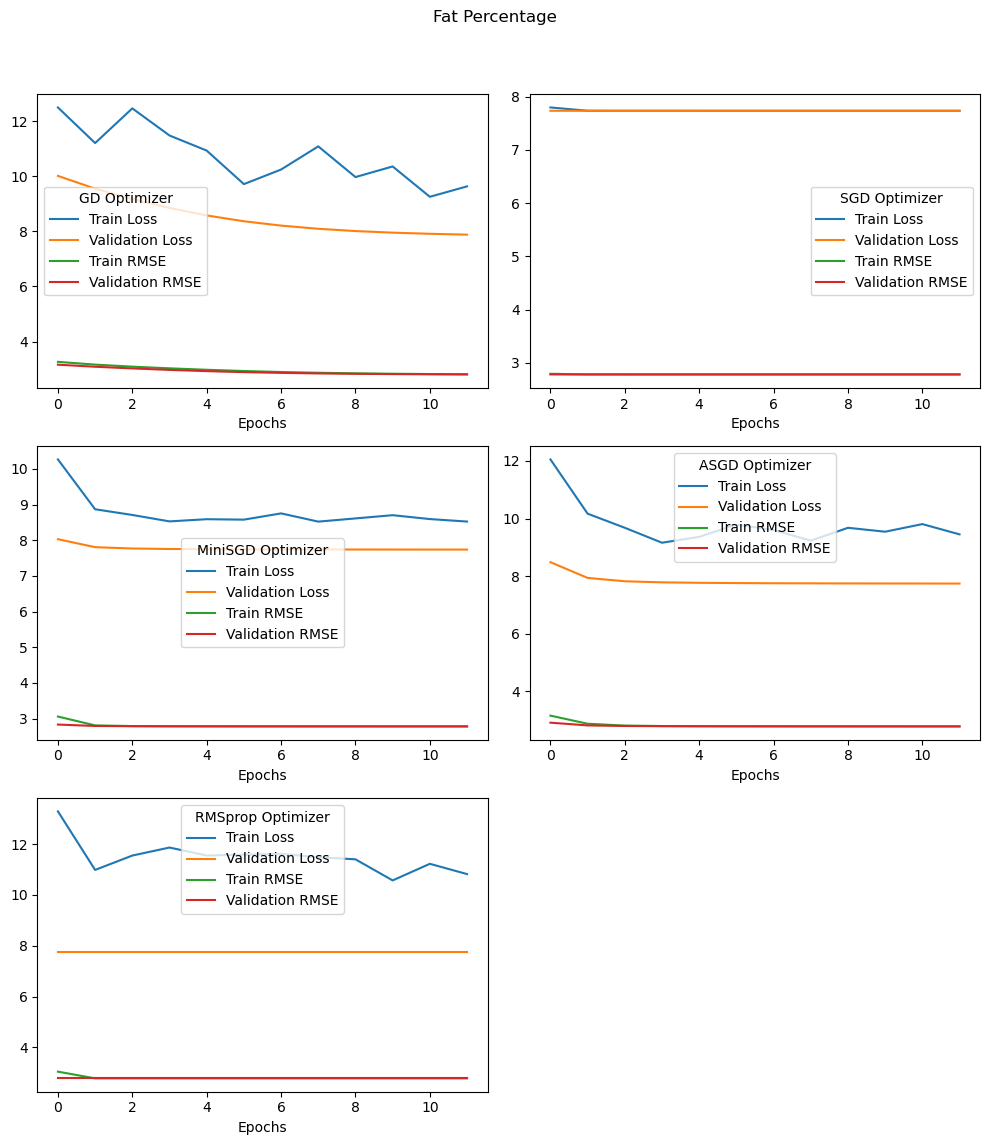

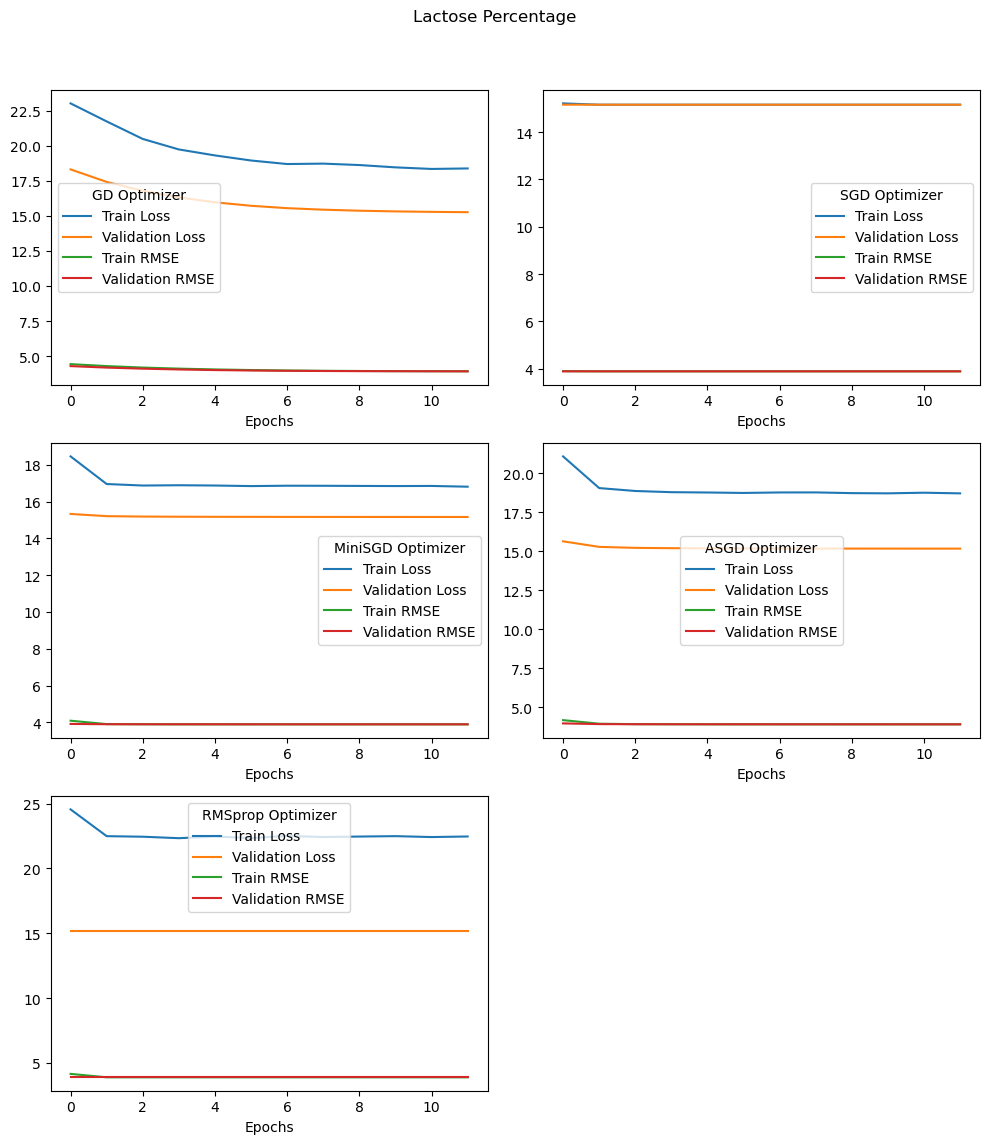

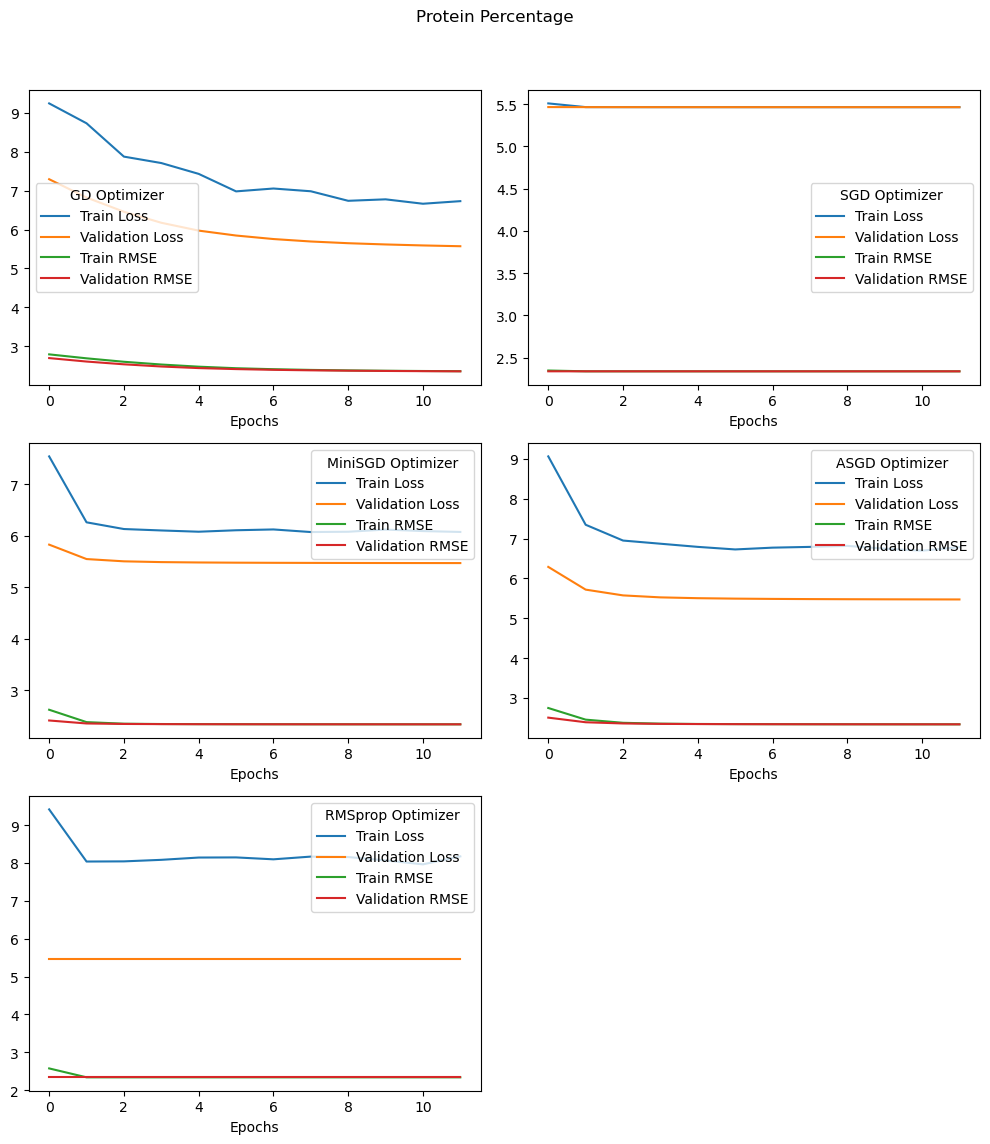

In [27]:
def plot_results(history, title):
    plt.figure(figsize=(10, 12))
    num_plots = len(history.keys())
    rows = 3
    cols = (num_plots + rows - 1) // rows
    
    for i, (nn_name, data) in enumerate(history.items(), 1):
        plt.subplot(rows, cols, i)
        plt.plot(data['metric_0'], label='Train Loss')
        plt.plot(data['metric_1'], label='Validation Loss')
        plt.plot(data['metric_2'], label='Train RMSE')
        plt.plot(data['metric_3'], label='Validation RMSE')
        plt.xlabel('Epochs')
        plt.legend(title=nn_name + ' Optimizer')
    
    plt.suptitle(title)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to fit the suptitle
    plt.show()

# Plot results 
plot_results(avg_history_fat, "Fat Percentage")
plot_results(avg_history_lactose, "Lactose Percentage")
plot_results(avg_history_protein, "Protein Percentage")


## GSGP

In [28]:
#We initialize the log file where we are going to store the data of the gsgp.
seed = 1
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'mps' if torch.backends.mps.is_available() else 'cpu'
shuffle, p_test, p_val, n_batches_pct = True, .3, .3, 1

# Setup logging properties
file_dir = './log/'
file_name = 'intro_gsgp.log'
log_path = file_dir + file_name
path_rts = os.path.join(file_dir, 'reconstruct', 'rts')
path_init_pop = os.path.join(file_dir, 'reconstruct', 'init_pop')

#if os.path.exists(file_dir + file_name):
    #os.remove(file_dir + file_name)
if not os.path.exists(file_dir):
    os.makedirs(file_dir)

for path_i in [file_dir, path_init_pop, path_rts]:
    if not os.path.exists(path_i):
        os.makedirs(path_i)

print([log_path, path_rts, path_init_pop])

['./log/intro_gsgp.log', './log/reconstruct\\rts', './log/reconstruct\\init_pop']


In [29]:
# Store RMSE values for GSGP model
gsgp_rmse_valid_fat = []
gsgp_rmse_valid_lactose = []
gsgp_rmse_valid_protein = []

# Loop over each kfold so is 5 times.
mh = []
for target_index in range(len(X_train_kf)):
    # Initialize an empty list to store RMSE values for each epoch
    target_rmse_values = []
    
    # Transform the dataset of the train and validation to tensor then to data loader so it works on the function
    batch_size = len(X_train_kf[target_index])
    ds_train_kf = TensorDataset(X_train_kf[target_index], y_lactose_train_kf[target_index])
    ds_val_kf = TensorDataset(X_val_kf[target_index], y_lactose_val_kf[target_index])
    dl_train_1 = DataLoader(ds_train_kf, batch_size, shuffle)
    dl_val_1 = DataLoader(ds_val_kf, batch_size, shuffle)
    #initializing the parameters into the SML
    fset = [function_map['add'], function_map['sub'], function_map['mul'], function_map['div']]
    sspace_sml_gs = {
        'n_dims': X_train_kf[target_index].shape[1],
        'function_set': fset, 'constant_set': ERC(-1., 1.),
        'p_constants': 0.1,
        'max_init_depth': 3,
        'device': device,
        'n_batches': 1
    }
    #SML wiht rmse
    pi_sml = SML(
        sspace=sspace_sml_gs,
        ffunction=Ffunctions('rmse'),
        dl_train=dl_train_1, dl_test=dl_val_1
    )
    
    #Parameters initialize for the Genetic Algorithm
    ps = batch_size
    selection_pressure = .07
    mutation_prob = .1
    xo_prob = .9
    seed = 1
    has_elitism = True
    allow_reproduction = False
    to, by = 5.0, 0.25
    ms = torch.arange(by, to + by, by, device=device)
    #Initialize Genetic Algorithm
    mheuristic = GeneticAlgorithm(
        pi=pi_sml,
        initializer=grow,
        selector=prm_tournament(pressure=selection_pressure),
        pop_size=ps,
        p_m=mutation_prob,
        p_c=xo_prob,
        elitism=has_elitism,
        reproduction=allow_reproduction,  # False = or xo or mutation
        device=device,
        seed=seed,
        crossover=prm_gs_xo(prm_grow(sspace=pi_sml.sspace), device=device),
        mutator=prm_gs_mtn(prm_grow(sspace=pi_sml.sspace), ms)
    )
    mheuristic._initialize()
    #Save the model into an array to have a model for each fold
    mh.append(mheuristic)

In [30]:
n_iter = 12
#Run the array with each model and solve it so it saves the result into the intr_gsgp.log file
for i in range(0,len(mh)):
    mh[i].solve(
        n_iter=n_iter,
        verbose=3, log=2, log_path=log_path,
        test_elite=True
    )

./log/intro_gsgp.log 1
./log/intro_gsgp.log 2
-------------------------------------------------------------------------------------------------------
           |                    Best solution                      |            Population            |
-------------------------------------------------------------------------------------------------------
Generation | Length   Fitness          Test Fitness         Timing | AVG Fitness           STD Fitness
-------------------------------------------------------------------------------------------------------
0          | 3        3.89611          3.88257               0.180 | -1                             -1
1          | 3        3.89611          3.88257               0.466 | -1                             -1
2          | 43       3.76413          3.72589               0.763 | -1                             -1
3          | 78       2.73631          3.26967               1.102 | -1                             -1
4          | 85       2

In [31]:
# Open log file
rows = []
with open(log_path, 'r') as file:
     # Create a CSV reader object
    csv_reader = csv.reader(file)
    # Iterate over each row in the CSV file
    for row in csv_reader:
        # Process each row (each row is a list of values)
        rows.append(row)
#Here is reading the fil and is separating each fold
gsgp_data = []
gsgp_d = []
for i in range(0, len(rows)):
    row = rows[i]
    if row[4] == '0':
        gsgp_data.append(gsgp_d)
        gsgp_d = [row]
    else:
        gsgp_d.append(row)
gsgp_data.append(gsgp_d)

history_fits= []
history_test_fits = []
history_sizes = []
history_timing = []

#It splits the data and then calculates the average of each epoc thats why /5 so epoch 1 for first fold then add the 5 fold
#of epoch 1 then /5
for i in range(0,n_iter):
# Fitness history
    history_f = 0
    history_t_f = 0
    history_s = 0
    history_t = 0
    for j in range(1, 6):
        g_d = gsgp_data[j]
        history_f += float(g_d[i][7].split('(')[1].split(')')[0])
        history_t_f += float(g_d[i][9])
        history_s += float(g_d[i][6])
        history_t += float(g_d[i][5])
    history_fits.append(history_f/5)
    history_test_fits.append(history_t_f/5)
    history_sizes.append(history_s/5)
    history_timing.append(history_t)
    


In [32]:

print(len(history_fits))

        

12


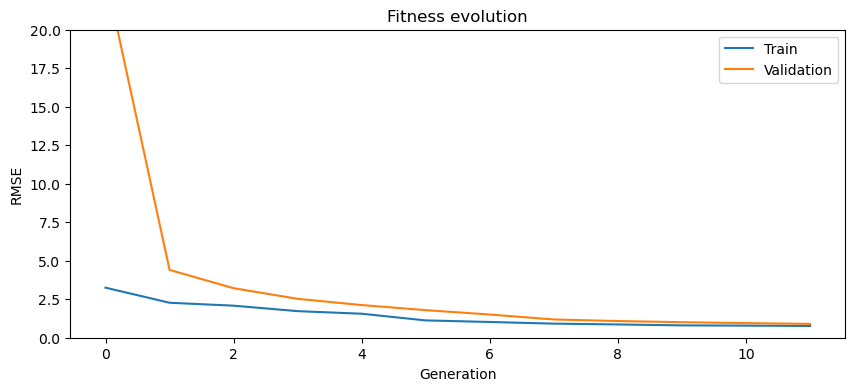

Best solution RMSE fitness: 1.38 train, 1.45 test.



In [33]:
#Graph RMSE vs generation
plt.figure(figsize=(10, 4))

plt.plot(history_fits, label='Train')
plt.plot(history_test_fits, label='Validation')
plt.title('Fitness evolution')
plt.xlabel('Generation')
plt.ylabel('RMSE')
plt.ylim(bottom=0, top=20)
plt.legend()
plt.show()

print('Best solution RMSE fitness: {:.2f} train, {:.2f} test.\n'.format(mh[0].best_sol.fit.item(), mh[0].best_sol.test_fit.item()))


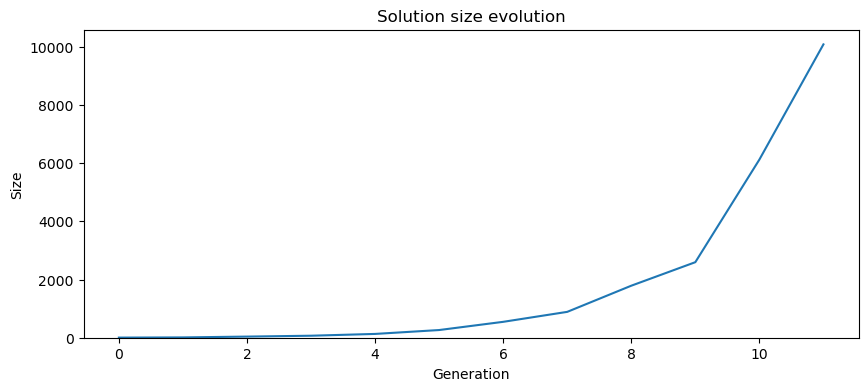

In [34]:
#Graph Size generation
plt.figure(figsize=(10, 4))

plt.plot(history_sizes)
plt.title('Solution size evolution')
plt.xlabel('Generation')
plt.ylabel('Size')
plt.ylim(bottom=0)
plt.show()


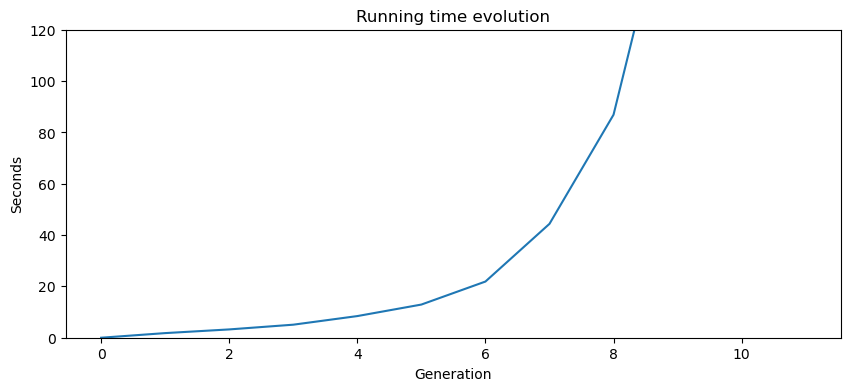

Total time: 32.22 minutes.



In [35]:
#Time vs generation
plt.figure(figsize=(10, 4))

plt.plot(history_timing)
plt.title('Running time evolution')
plt.xlabel('Generation')
plt.ylabel('Seconds')
plt.ylim(bottom=0, top=120)
plt.show()

print('Total time: {:.2f} minutes.\n'.format(sum(history_timing)/60.))

## GSGP EFFICIENT

In [36]:
mh_gsgpE = []

#We proceed to do the same steps for GSGP except here we are using index and other dataset for the SMLGS function.
for i in range(0, len(X_train_kf)):
    batch_size = len(X_train_kf[i])
    
    fset = [function_map['add'], function_map['sub'], function_map['mul'], function_map['div'], function_map['exp'],
                function_map['log']]
    train_indices = []
    val_indices = []
    for j in range(0, len(X_train_kf[i])):
        train_indices.append(j)
        val_indices.append(j)
    train_index = torch.tensor(train_indices)
    val_index = torch.tensor(val_indices)

    sspace_sml_gs = {
        'n_dims': X_train_kf[i].shape[1],
        'function_set': fset, 'constant_set': ERC(-1., 1.),
        'p_constants': 0.1,
        'max_init_depth': 3,
        'device': device
    }
    pi_sml_gs = SMLGS(
        sspace=sspace_sml_gs,
        ffunction=Ffunctions('rmse'),
        X=X_train_kf[i], y=y_lactose_train_kf[i],
        train_indices=train_index,
        test_indices=val_index
    )


    ps = batch_size

    # ps = 250
    selection_pressure = .07
    mutation_prob = .7
    xo_prob = .3
    has_elitism = True
    allow_reproduction = False

    mheuristic = GSGP(
        pi=pi_sml_gs,
        #
        # If individuals should be reconstructed, it must be defined before fitting the algorithm.
        #
        path_init_pop=path_init_pop, 
        path_rts=path_rts, 
        #
        # Initializer - it can be the same tree initializer as traditional GP.
        #
        initializer=grow,
        #
        # Selector - it can be the same GP selector as tradicional GP.
        #
        selector=prm_tournament(pressure=selection_pressure),
        #
        # Other Algorithm hyperparameters
        #
        pop_size=ps,
        p_m=mutation_prob,
        p_c=xo_prob,
        elitism=has_elitism,
        reproduction=allow_reproduction,  # False = or xo or mutation
        device=device,
        seed=seed,
        #
        # Efficient Crossover
        #
        crossover=prm_efficient_gs_xo(X_train_kf[i], prm_grow(sspace=pi_sml_gs.sspace)),
        #
        # Efficient Mutation
        #
        mutator=prm_efficient_gs_mtn(X_train_kf[i], prm_grow(sspace=pi_sml_gs.sspace), ms)
    )
    mheuristic._initialize()
    mh_gsgpE.append(mheuristic)

In [37]:
# Setup logging properties
#We will write on the same log file but afterwards
file_dir = './log/'
file_name = 'intro_gsgp.log'
log_path = file_dir + file_name

# If GSGP solution should be reconstructed, the paths for persisting 
# the needed objects should be set.
path_rts = os.path.join(file_dir, 'reconstruct', 'rts')
path_init_pop = os.path.join(file_dir, 'reconstruct', 'init_pop')


if not os.path.exists(file_dir):
    os.makedirs(file_dir)

for path_i in [file_dir, path_init_pop, path_rts]:
    if not os.path.exists(path_i):
        os.makedirs(path_i)



In [38]:
n_iter = 12
#Run the solve same as before
for i in range(0,len(mh_gsgpE)):
    mh_gsgpE[i].solve(
     n_iter=n_iter,
     verbose=3, log=2, log_path=log_path,
     test_elite=True
 )

./log/intro_gsgp.log 3
-------------------------------------------------------------------------------------------------------
           |                    Best solution                      |            Population            |
-------------------------------------------------------------------------------------------------------
Generation | Depth    Fitness          Test Fitness         Timing | AVG Fitness           STD Fitness
-------------------------------------------------------------------------------------------------------
0          | 2        2.18764          2.18764               0.302 | 383.93                    2030.84
1          | 5        0.212047         0.212047              0.412 | 3.28052                   1.26678
2          | 6        0.212047         0.212047              0.458 | 1.63382                  0.979717
3          | 8        0.211786         0.211786              0.358 | 1.34211                   1.07625
4          | 10       0.167006         0.16700

In [39]:
# Open log file
rows = []
with open(log_path, 'r') as file:
    # Create a CSV reader object
    csv_reader = csv.reader(file)
    # Iterate over each row in the CSV file
    for row in csv_reader:
        # Process each row (each row is a list of values)
        rows.append(row)
rows2 = []
c = 0
#In orther to identify is the GSGP Efficient is called GPOLNEL
for row in rows:
    if '1:GSGP-GPOLNEL' in row:
        if c == 1:
            rows2.append(row)
        else: 
            c=1

#Sames steps as before
gsgp_eff_data = []
gsgp_eff_d = []
for i in range(0, len(rows2)):
    row = rows2[i]
    if row[4] == '0':
        gsgp_eff_data.append(gsgp_eff_d)
        gsgp_eff_d = [row]
    else:
        gsgp_eff_d.append(row)
gsgp_eff_data.append(gsgp_eff_d)

history_eff_fits= []
history_eff_test_fits = []
history_eff_sizes = []
history_eff_timing = []


for i in range(0,n_iter):
# Fitness history
    history_f = 0
    history_t_f = 0
    history_s = 0
    history_t = 0
    for j in range(0, 5):
        g_d = gsgp_eff_data[j]
        history_f += float(g_d[i][7].split('(')[1].split(')')[0])
        history_t_f += float(g_d[i][9])
        history_s += float(g_d[i][6].split('(')[1].split(')')[0])
        history_t += float(g_d[i][5])
    history_eff_fits.append(history_f/5)
    history_eff_test_fits.append(history_t_f/5)
    history_eff_sizes.append(history_s/5)
    history_eff_timing.append(history_t)
    

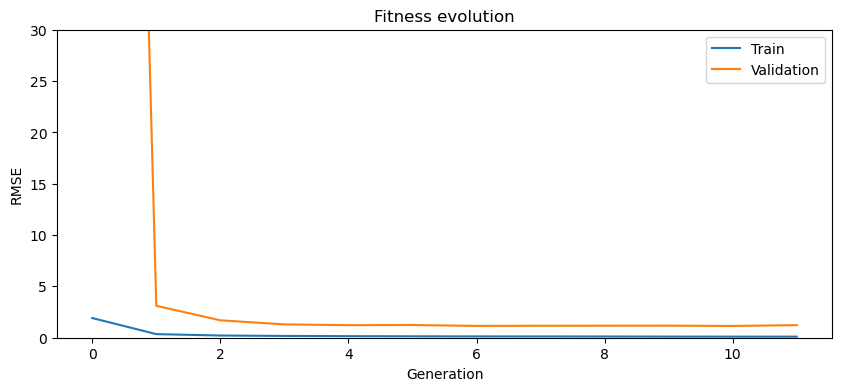

Best solution RMSE fitness: 0.11 train, 0.11 test.



In [40]:
plt.figure(figsize=(10, 4))

plt.plot(history_eff_fits, label='Train')
plt.plot(history_eff_test_fits, label='Validation')
plt.title('Fitness evolution')
plt.xlabel('Generation')
plt.ylabel('RMSE')
plt.ylim(bottom=0, top=30)
plt.legend()
plt.show()

print('Best solution RMSE fitness: {:.2f} train, {:.2f} test.\n'.format(mh_gsgpE[0].best_sol.fit.item(), mh_gsgpE[0].best_sol.test_fit.item()))


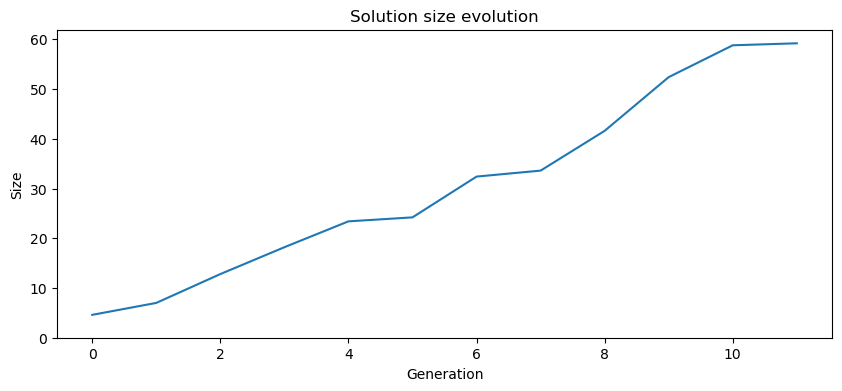

In [41]:
plt.figure(figsize=(10, 4))

plt.plot(history_eff_sizes)
plt.title('Solution size evolution')
plt.xlabel('Generation')
plt.ylabel('Size')
plt.ylim(bottom=0)
plt.show()


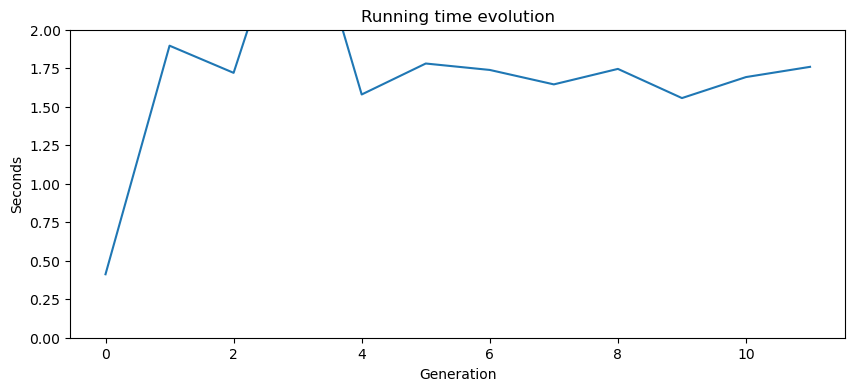

Total time: 32.22 minutes.



In [42]:
plt.figure(figsize=(10, 4))

plt.plot(history_eff_timing)
plt.title('Running time evolution')
plt.xlabel('Generation')
plt.ylabel('Seconds')
plt.ylim(bottom=0, top=2)
plt.show()

print('Total time: {:.2f} minutes.\n'.format(sum(history_timing)/60.))

## GA/GP

In [43]:
mh_gp = []
#Same steps with GSGP
for target_index in range(len(X_train_kf)):
    # Initialize an empty list to store RMSE values for each epoch
    target_rmse_values = []
    
    # Code to train GP model for each k fold
    batch_size = len(X_train_kf[target_index])
    ds_train_kf = TensorDataset(X_train_kf[target_index], y_lactose_train_kf[target_index])
    ds_val_kf = TensorDataset(X_val_kf[target_index], y_lactose_val_kf[target_index])
    dl_train_1 = DataLoader(ds_train_kf, batch_size, shuffle)
    dl_val_1 = DataLoader(ds_val_kf, batch_size, shuffle)
        
    seed = 1
    # device = 'cuda' if torch.cuda.is_available() else 'cpu'
    device = 'mps' if torch.backends.mps.is_available() else 'cpu'
        
    # Defines parameters for the data usage
    shuffle, p_test, p_val, n_batches_pct = True, .3, .3, 1
    
    fset = [function_map['add'], function_map['sub'], function_map['mul'], function_map['div']]
    
    sspace_sml = {
        'n_dims': X.shape[1],
        'function_set': fset, 'constant_set': ERC(-1., 1.),
        'p_constants': 0.1,
        'max_init_depth': 3,
        'max_depth': 10, 
        'n_batches': 1,
        'device': device
    }
    pi_sml = SML(
        sspace=sspace_sml,
        ffunction=Ffunctions('rmse'),
        dl_train=dl_train_1, dl_test= dl_val_1,  # For the algorithm, the unseen is our validation!
        n_jobs=8
    )
    
    
    ps = 249
    selection_pressure = .07
    mutation_prob = .3
    xo_prob = .7
    has_elitism = True
    allow_reproduction = False
    
    mheuristic = GeneticAlgorithm(
        pi=pi_sml,
        initializer=grow,
        selector=prm_tournament(pressure=selection_pressure),
        crossover=swap_xo,
        mutator=prm_subtree_mtn(initializer=prm_grow(sspace_sml)),
        pop_size=ps,
        p_m=mutation_prob,
        p_c=xo_prob,
        elitism=has_elitism,
        reproduction=allow_reproduction,  # False = or xo or mutation
        device=device,
        seed=seed
    )
    mheuristic._initialize()
    mh_gp.append(mheuristic)
    
print(mh_gp)
    


[<gpolnel.algorithms.genetic_algorithm.GeneticAlgorithm object at 0x00000185D17D1690>, <gpolnel.algorithms.genetic_algorithm.GeneticAlgorithm object at 0x00000185D17AE010>, <gpolnel.algorithms.genetic_algorithm.GeneticAlgorithm object at 0x00000185D12FBAD0>, <gpolnel.algorithms.genetic_algorithm.GeneticAlgorithm object at 0x00000185D17E4AD0>, <gpolnel.algorithms.genetic_algorithm.GeneticAlgorithm object at 0x00000185D1180DD0>]


In [44]:
mheuristic.pop.individuals[0].printTree()
boston_features = ['crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'tax', 'ptratio', 'lstat', 'medv']
mheuristic.pop.individuals[0].printTree(feature_names=boston_features)

sub( mul( div( x_12, -0.9433 ) x_0 ) x_7 )
sub( mul( div( medv, -0.9433 ) crim ) dis )


In [45]:
#print(f'\nGP population: {mheuristic.pop._class_} ({len(mheuristic.pop)} individuals)')

print(f'\nPoppulation fitness {mheuristic.pop.fit[:3]}...')
print(f'Poppulation valid {mheuristic.pop.valid[:3]}...\n')

for i in range(3):
    print(f'Individual {i}: {mheuristic.pop.individuals[i].repr_}, fitness {mheuristic.pop.individuals[i].fit}')

print(f'\nGP best individual {mheuristic.best_sol.printTree(out="string")}, fitness {mheuristic.best_sol.fit}\n\n')

# Log settings
file_dir = './log/'
file_name = 'intro1.log'
log_path = file_dir + file_name
print("----------------")
print(file_dir)
if os.path.exists(file_dir + file_name):
    os.remove(file_dir + file_name)
if not os.path.exists(file_dir):
    os.makedirs(file_dir)

n_iter = 12


Poppulation fitness tensor([5.2192, 4.5630, 4.8702])...
Poppulation valid [True, True, True]...

Individual 0: [sub, mul, div, 12, tensor(-0.9433), 0, 7], fitness 5.219175815582275
Individual 1: [add, add, 0, 13, sub, 17, 7], fitness 4.562962532043457
Individual 2: [div, div, 9, 16, 6], fitness 4.870229721069336

GP best individual add( x_5, div( div( -0.3242, x_11 ) x_18 ) ), fitness 3.5525259971618652


----------------
./log/


In [46]:
n_iter = 12
#Saves the solution on the same log file after GSGP Efficient
for i in range(0,len(mh_gp)):
    mh_gp[i].solve(
        n_iter,
        verbose=3, log=3, log_path=log_path,
        test_elite=True
    )

./log/intro1.log 1
./log/intro1.log 2
-------------------------------------------------------------------------------------------------------
           |                    Best solution                      |            Population            |
-------------------------------------------------------------------------------------------------------
Generation | Length   Fitness          Test Fitness         Timing | AVG Fitness           STD Fitness
-------------------------------------------------------------------------------------------------------
0          | 7        2.93353          8.36196               0.461 | -1                             -1
1          | 7        2.90973          6.25369               0.432 | -1                             -1
2          | 11       1.91107          5.8911                0.448 | -1                             -1
3          | 19       0.243653         18.0886               0.430 | -1                             -1
4          | 19       0.243653 

In [47]:
# Open log file
rows = []
log_path = './log/intro_gsgp.log'
with open(log_path, 'r') as file:
    # Create a CSV reader object
    csv_reader = csv.reader(file)
    # Iterate over each row in the CSV file
    for row in csv_reader:
        # Process each row (each row is a list of values)
        rows.append(row)
rows3 = []
c = 0
#To identify is GP 
for row in rows:
    if len(row)>11:
        if c == 1:
            rows3.append(row)
        else:
            if row[4] =='0':
                c = 1


#Same steps as GSGP
ga_data = []
ga_d = []
for i in range(0, len(rows3)):
    row = rows3[i]
    if row[4] == '0':
        ga_data.append(ga_d)
        ga_d = [row]
    else:
        ga_d.append(row)
        
ga_data.append(ga_d)

history_ga_fits= []
history_ga_test_fits = []
history_ga_sizes = []
history_ga_timing = []


for i in range(0,n_iter):
# Fitness history
    history_f = 0
    history_t_f = 0
    history_s = 0
    history_t = 0
    for j in range(0, 5):
        g_d = ga_data[j]
        history_f += float(g_d[i][7].split('(')[1].split(')')[0])
        history_t_f += float(g_d[i][9])
        history_s += float(g_d[i][6])
        history_t += float(g_d[i][5])
    history_ga_fits.append(history_f/5)
    history_ga_test_fits.append(history_t_f/5)
    history_ga_sizes.append(history_s/5)
    history_ga_timing.append(history_t)

In [48]:
print(history_ga_fits)

[3.46408, 2.5035000000000003, 1.3873000000000002, 0.8914799999999999, 0.48714, 0.3002, 0.17630000000000004, 0.16832, 0.15552, 0.1545, 0.15062000000000003, 0.14524]


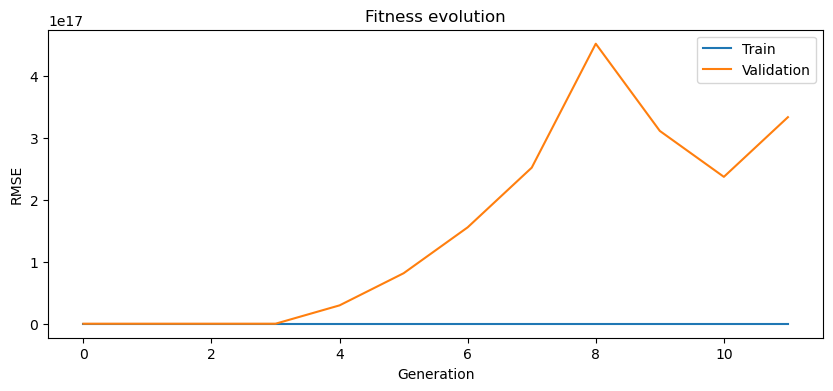

Best solution RMSE fitness: 0.13 train, 0.63 validation.



In [49]:
plt.figure(figsize=(10, 4))

plt.plot(history_ga_fits, label='Train')
plt.plot(history_ga_test_fits, label='Validation')
plt.title('Fitness evolution')
plt.xlabel('Generation')
plt.ylabel('RMSE')

plt.legend()
plt.show()

print('Best solution RMSE fitness: {:.2f} train, {:.2f} validation.\n'.format(mheuristic.best_sol.fit.item(), mheuristic.best_sol.test_fit.item()))

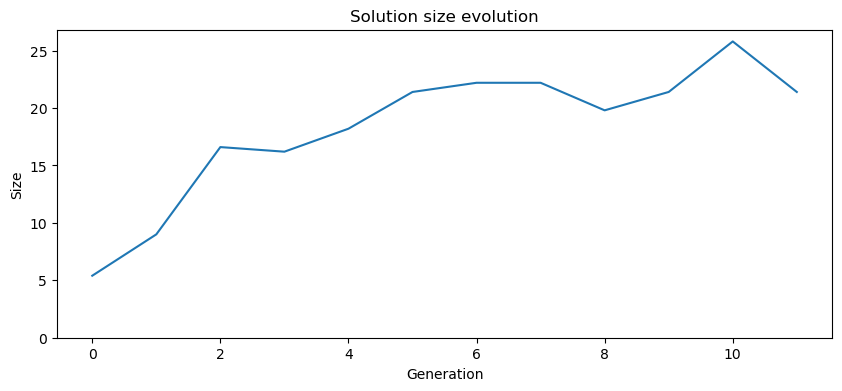

In [50]:
plt.figure(figsize=(10, 4))

plt.plot(history_ga_sizes)
plt.title('Solution size evolution')
plt.xlabel('Generation')
plt.ylabel('Size')
plt.ylim(bottom=0)
plt.show()

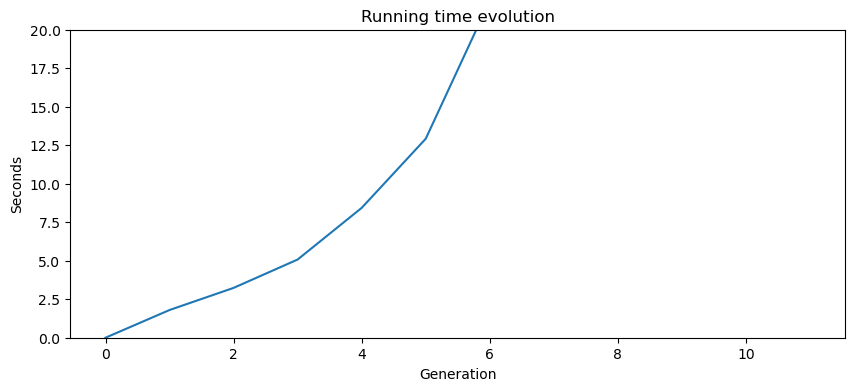

Total time: 32.22 minutes.



In [51]:
plt.figure(figsize=(10, 4))

plt.plot(history_timing)
plt.title('Running time evolution')
plt.xlabel('Generation')
plt.ylabel('Seconds')
plt.ylim(bottom=0, top=20)
plt.show()

print('Total time: {:.2f} minutes.\n'.format(sum(history_timing)/60.))

## For GA data:
- history_ga_fits

- history_ga_test_fits

- history_ga_sizes

- history_ga_timing

## For GSGP
- history_gsgp_fits

- history_gsgp_test_fits

- history_gsgp_sizes

- history_gsgp_timing

## For GSGP Efficient
- history_eff_fits

- history_eff_test_fits

- history_eff_sizes

- history_eff_timing

# NEAT

In [29]:
device = 'cpu'
temp_config_path = "temp_config_feedforward_xor.txt"

class StdOutReporter(neat.reporting.BaseReporter):
    def post_evaluate(self, config, population, species, best_genome):
        fit_mean = np.mean([g.fitness for g in population.values() if g.fitness is not None])
        fit_std = np.std([g.fitness for g in population.values() if g.fitness is not None])

        best_species_id = species.get_species_id(best_genome.key)
        best_fitness = float(best_genome.fitness)
        print('Population\'s average fitness: {0:3.5f} stdev: {1:3.5f}'.format(fit_mean, fit_std))
        print('Best fitness: {0:3.5f} - size: {1!r} - species {2} - id {3}'.format(best_fitness,
                                                                                     best_genome.size(),
                                                                                     best_species_id,
                                                                                     best_genome.key))

def run_neat_for_target(inputs, outputs, config, num_generations=15):
    pop = neat.Population(config)
    pop.add_reporter(neat.StdOutReporter(True))
    pop.add_reporter(StdOutReporter())
    stats = neat.StatisticsReporter()
    pop.add_reporter(stats)

    # Function to calculate fitness for each genome
    def eval_genomes(genomes, config):
        for genome_id, genome in genomes:
            net = neat.nn.FeedForwardNetwork.create(genome, config)
            squared_errors = []
            for xi, xo in zip(inputs, outputs):
                output = net.activate(xi)
                squared_errors.append((output[0] - xo) ** 2)
            mse = np.mean(squared_errors)
            rmse = np.sqrt(mse)
            genome.fitness = -rmse  # NEAT maximizes fitness, so we use negative RMSE

    # Run NEAT and collect fitness history
    fitness_history = []

    for gen in range(num_generations):
        pop.run(eval_genomes, 1)
        gen_fitnesses = [-genome.fitness for genome in pop.population.values() if genome.fitness is not None]
        gen_rmse = np.mean(gen_fitnesses)
        fitness_history.append(gen_rmse)

    return fitness_history

# Load configuration file with UTF-8 encoding
config_path = "config-feedforward-xor"
temp_config_path = "temp_config_feedforward_xor"

# Read the configuration file with UTF-8 encoding, and handle errors
with open(config_path, 'r', encoding='utf-8', errors='replace') as f:
    content = f.read()

# Remove problematic characters
cleaned_content = ''.join(c for c in content if ord(c) < 128)

# Write cleaned content to a temporary file with UTF-8 encoding
with open(temp_config_path, 'w', encoding='utf-8') as f:
    f.write(cleaned_content)

# Load configuration using the temporary file
config = neat.config.Config(neat.DefaultGenome, neat.DefaultReproduction,
                            neat.DefaultSpeciesSet, neat.DefaultStagnation,
                            temp_config_path)

# Train NEAT models for each target
num_generations = 12
target_rmse = {
    'lactose': [[] for _ in range(num_generations)],
    'fat': [[] for _ in range(num_generations)],
    'protein': [[] for _ in range(num_generations)]
}

for fold_idx in range(len(X_train_kf)):
    X_train_fold = X_train_kf[fold_idx]
    y_fat_train_fold = y_fat_train_kf[fold_idx]
    y_lactose_train_fold = y_lactose_train_kf[fold_idx]
    y_protein_train_fold = y_protein_train_kf[fold_idx]

    # Convert data to numpy arrays
    X_train_fold_np = X_train_fold.cpu().numpy()
    y_fat_train_fold_np = y_fat_train_fold.cpu().numpy()
    y_lactose_train_fold_np = y_lactose_train_fold.cpu().numpy()
    y_protein_train_fold_np = y_protein_train_fold.cpu().numpy()
    
    # Run NEAT for each target
    lactose_rmse = run_neat_for_target(X_train_fold_np, y_lactose_train_fold_np, config, num_generations)
    fat_rmse = run_neat_for_target(X_train_fold_np, y_fat_train_fold_np, config, num_generations)
    protein_rmse = run_neat_for_target(X_train_fold_np, y_protein_train_fold_np, config, num_generations)
    
    for gen in range(num_generations):
        target_rmse['lactose'][gen].append(lactose_rmse[gen])
        target_rmse['fat'][gen].append(fat_rmse[gen])
        target_rmse['protein'][gen].append(protein_rmse[gen])

# Calculate average RMSE for each epoch across folds
average_rmse_neat = {
    'lactose': [np.mean(rmses) for rmses in target_rmse['lactose']],
    'fat': [np.mean(rmses) for rmses in target_rmse['fat']],
    'protein': [np.mean(rmses) for rmses in target_rmse['protein']]
}



 ****** Running generation 0 ****** 

Population's average fitness: -4.89600 stdev: 0.00000
Best fitness: -4.89600 - size: (1, 0) - species 1 - id 1
Population's average fitness: -4.89600 stdev: 0.00000
Best fitness: -4.89600 - size: (1, 0) - species 1 - id 1
Average adjusted fitness: 0.000
Mean genetic distance 2.343, standard deviation 1.433
Population of 100 members in 3 species:
   ID   age  size   fitness   adj fit  stag
  ====  ===  ====  =========  =======  ====
     1    0    77     -4.896    0.000     0
     2    0    20     -4.896    0.000     0
     3    0     3         --       --     0
Total extinctions: 0
Generation time: 0.074 sec

 ****** Running generation 1 ****** 

Population's average fitness: -4.86452 stdev: 0.15685
Best fitness: -3.73555 - size: (1, 1) - species 3 - id 178
Population's average fitness: -4.86452 stdev: 0.15685
Best fitness: -3.73555 - size: (1, 1) - species 3 - id 178
Average adjusted fitness: 0.119
Mean genetic distance 2.956, standard deviation 

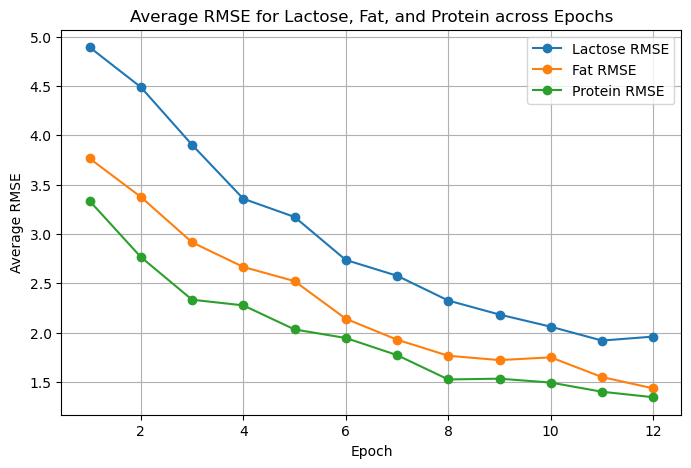

In [30]:
# Plot the RMSE values for each target
epochs = range(1, num_generations + 1)

plt.figure(figsize=(8, 5))
plt.plot(epochs, average_rmse_neat['lactose'], label='Lactose RMSE', marker='o')
plt.plot(epochs, average_rmse_neat['fat'], label='Fat RMSE', marker='o')
plt.plot(epochs, average_rmse_neat['protein'], label='Protein RMSE', marker='o')

plt.xlabel('Epoch')
plt.ylabel('Average RMSE')
plt.title('Average RMSE for Lactose, Fat, and Protein across Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Wilcoxon Signed-Rank Test

#### Between NN and NEAT

In [57]:
# Function to average RMSE values across optimizers (NN)
def average_rmse_across_optimizers(history):
    avg_rmse_train = []
    avg_rmse_valid = []
    for nn_name, folds_history in history.items():
        rmse_train_folds = []
        rmse_valid_folds = []
        for fold_name, metrics in folds_history.items():
            _, _, rmse_train, rmse_valid = metrics
            rmse_train_folds.append(rmse_train)
            rmse_valid_folds.append(rmse_valid)
        avg_rmse_train.append(np.mean(rmse_train_folds, axis=0))
        avg_rmse_valid.append(np.mean(rmse_valid_folds, axis=0))
    return np.mean(avg_rmse_train, axis=0), np.mean(avg_rmse_valid, axis=0)

# Average RMSE values across optimizers for each target (NN)
avg_rmse_train_fat, avg_rmse_valid_fat = average_rmse_across_optimizers(history_kfold_fat)
avg_rmse_train_lactose, avg_rmse_valid_lactose = average_rmse_across_optimizers(history_kfold_lactose)
avg_rmse_train_protein, avg_rmse_valid_protein = average_rmse_across_optimizers(history_kfold_protein)

# Use NEAT RMSE values
neat_rmse_fat = average_rmse_neat['fat']
neat_rmse_lactose = average_rmse_neat['lactose']
neat_rmse_protein = average_rmse_neat['protein']

# Perform Wilcoxon Signed-Rank Test
def perform_wilcoxon_test(avg_rmse_nn, neat_rmse, target_variable):
    
    min_length = min(len(avg_rmse_nn), len(neat_rmse))
    avg_rmse_nn = avg_rmse_nn[:min_length]
    neat_rmse = neat_rmse[:min_length]
    
    stat, p_value = wilcoxon(avg_rmse_nn, neat_rmse)
    print(f"Wilcoxon test for {target_variable} RMSE: statistic={stat}, p-value={p_value}")

# Perform tests for each target variable
perform_wilcoxon_test(avg_rmse_valid_fat, neat_rmse_fat, "fat")
perform_wilcoxon_test(avg_rmse_valid_lactose, neat_rmse_lactose, "lactose")
perform_wilcoxon_test(avg_rmse_valid_protein, neat_rmse_protein, "protein")

Wilcoxon test for fat RMSE: statistic=0.0, p-value=0.00048828125
Wilcoxon test for lactose RMSE: statistic=0.0, p-value=0.00048828125
Wilcoxon test for protein RMSE: statistic=0.0, p-value=0.00048828125


#### Between NN and GSGP

In [54]:
# Function to average RMSE values across optimizers (NN)
def average_rmse_across_optimizers(history):
    avg_rmse_train = []
    avg_rmse_valid = []
    for optimizer_name, folds_history in history.items():
        rmse_train_folds = []
        rmse_valid_folds = []
        for fold_name, metrics in folds_history.items():
            _, _, rmse_train, rmse_valid = metrics
            rmse_train_folds.append(rmse_train)
            rmse_valid_folds.append(rmse_valid)
        avg_rmse_train.append(np.mean(rmse_train_folds, axis=0))
        avg_rmse_valid.append(np.mean(rmse_valid_folds, axis=0))
    return np.mean(avg_rmse_train, axis=0), np.mean(avg_rmse_valid, axis=0)

# Average RMSE values across optimizers for each target (NN)
avg_rmse_train_lactose, avg_rmse_valid_lactose = average_rmse_across_optimizers(history_kfold_lactose)

# Use GSGP RMSE values
gsgp_rmse_lactose = history_test_fits

# Perform Wilcoxon Signed-Rank Test
def perform_wilcoxon_test(avg_rmse_nn, gsgp_rmse, target_variable):
    
    min_length = min(len(avg_rmse_nn), len(gsgp_rmse))
    avg_rmse_nn = avg_rmse_nn[:min_length]
    gsgp_rmse = gsgp_rmse[:min_length]
    
    stat, p_value = wilcoxon(avg_rmse_nn, gsgp_rmse)
    print(f"Wilcoxon test for {target_variable} RMSE: statistic={stat}, p-value={p_value}")

# Perform test for lactose
perform_wilcoxon_test(avg_rmse_valid_lactose, gsgp_rmse_lactose, "lactose")

Wilcoxon test for lactose RMSE: statistic=13.0, p-value=0.04248046875


#### Between GSGP and GSGP Efficient

In [55]:
# Use GSGP and GSGP Efficient RMSE values 
gsgp_rmse_lactose = history_test_fits

gsgp_efficient_rmse_lactose = history_eff_test_fits

# Perform Wilcoxon Signed-Rank Test between GSGP and GSGP Efficient
def perform_wilcoxon_test(gsgp_rmse, gsgp_efficient_rmse, target_variable):
    # Ensure both lists have the same length for a valid test
    min_length = min(len(gsgp_rmse), len(gsgp_efficient_rmse))
    gsgp_rmse = gsgp_rmse[:min_length]
    gsgp_efficient_rmse = gsgp_efficient_rmse[:min_length]
    
    stat, p_value = wilcoxon(gsgp_rmse, gsgp_efficient_rmse)
    print(f"Wilcoxon test for {target_variable} RMSE (GSGP vs GSGP Efficient): statistic={stat}, p-value={p_value}")

# Perform test for lactose
perform_wilcoxon_test(gsgp_rmse_lactose, gsgp_efficient_rmse_lactose, "lactose")

Wilcoxon test for lactose RMSE (GSGP vs GSGP Efficient): statistic=26.0, p-value=0.33935546875


#### Between GA and GSGP Efficient

In [56]:
# Use GA and GSGP Efficient RMSE values 
ga_rmse_lactose = history_ga_test_fits

gsgp_efficient_rmse_lactose = history_eff_test_fits

# Perform Wilcoxon Signed-Rank Test between GA and GSGP Efficient
def perform_wilcoxon_test(ga_rmse, gsgp_efficient_rmse, target_variable):
    
    min_length = min(len(ga_rmse), len(gsgp_efficient_rmse))
    ga_rmse = ga_rmse[:min_length]
    gsgp_efficient_rmse = gsgp_efficient_rmse[:min_length]
    
    stat, p_value = wilcoxon(ga_rmse, gsgp_efficient_rmse)
    print(f"Wilcoxon test for {target_variable} RMSE (GA vs GSGP Efficient): statistic={stat}, p-value={p_value}")

# Perform test for lactose
perform_wilcoxon_test(ga_rmse_lactose, gsgp_efficient_rmse_lactose, "lactose")

Wilcoxon test for lactose RMSE (GA vs GSGP Efficient): statistic=4.0, p-value=0.00341796875


#### Between GA and NEAT

In [57]:
# Use GA and NEAT RMSE values 
ga_rmse_lactose = history_ga_test_fits

# Use NEAT RMSE values 
neat_rmse_lactose = average_rmse_neat['lactose']

# Perform Wilcoxon Signed-Rank Test between GA and NEAT
def perform_wilcoxon_test(ga_rmse, neat_rmse, target_variable):
    
    min_length = min(len(ga_rmse), len(neat_rmse))
    ga_rmse = ga_rmse[:min_length]
    neat_rmse = neat_rmse[:min_length]
    
    stat, p_value = wilcoxon(ga_rmse, neat_rmse)
    print(f"Wilcoxon test for {target_variable} RMSE (GA vs NEAT): statistic={stat}, p-value={p_value}")

# Perform test for lactose
perform_wilcoxon_test(ga_rmse_lactose, neat_rmse_lactose, "lactose")

Wilcoxon test for lactose RMSE (GA vs NEAT): statistic=10.0, p-value=0.02099609375


# Friedman Test
##### Only between the ones that seem to be more similar based on Wilcoxon tests

#### Between GA, GSGP and GSGP Efficient

In [58]:
# Function to perform Friedman test for each target variable
def perform_friedman_test(ga_rmse, gsgp_rmse, gsgp_efficient_rmse, target_variable):
    
    min_length = min(len(ga_rmse), len(gsgp_rmse), len(gsgp_efficient_rmse))
    ga_rmse = ga_rmse[:min_length]
    gsgp_rmse = gsgp_rmse[:min_length]
    gsgp_efficient_rmse = gsgp_efficient_rmse[:min_length]
    
    # Perform the Friedman test
    stat, p_value = friedmanchisquare(ga_rmse, gsgp_rmse, gsgp_efficient_rmse)
    print(f"Friedman test for {target_variable} RMSE: statistic={stat}, p-value={p_value}")

ga_rmse_lactose = history_ga_test_fits
gsgp_rmse_lactose = history_test_fits
gsgp_efficient_rmse_lactose = history_eff_test_fits

# Perform Friedman test for lactose
perform_friedman_test(ga_rmse_lactose, gsgp_rmse_lactose, gsgp_efficient_rmse_lactose, "lactose")

Friedman test for lactose RMSE: statistic=12.666666666666657, p-value=0.0017761035457343876


#### Between NEAT, GSGP and GSGP Efficient

In [59]:
# Function to perform Friedman test for each target variable
def perform_friedman_test(neat_rmse, gsgp_rmse, gsgp_efficient_rmse, target_variable):
   
    min_length = min(len(neat_rmse), len(gsgp_rmse), len(gsgp_efficient_rmse))
    neat_rmse = neat_rmse[:min_length]
    gsgp_rmse = gsgp_rmse[:min_length]
    gsgp_efficient_rmse = gsgp_efficient_rmse[:min_length]
    
    # Perform the Friedman test
    stat, p_value = friedmanchisquare(neat_rmse, gsgp_rmse, gsgp_efficient_rmse)
    print(f"Friedman test for {target_variable} RMSE: statistic={stat}, p-value={p_value}")

neat_rmse_lactose = average_rmse_neat['lactose']
gsgp_rmse_lactose = history_test_fits
gsgp_efficient_rmse_lactose = history_eff_test_fits

# Perform Friedman test for lactose
perform_friedman_test(neat_rmse_lactose, gsgp_rmse_lactose, gsgp_efficient_rmse_lactose, "lactose")

Friedman test for lactose RMSE: statistic=15.166666666666657, p-value=0.0005088621855732938
